# Анализ рынка жилой недвижимости Санкт-Петербурга.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('real_estate_data.csv', sep='\t')

In [3]:
df.sample(5,random_state=1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
17338,5,3300000.0,47.0,2018-03-30T00:00:00,1,3.00,10.0,NaN,4,NaN,...,NaN,NaN,деревня Новое Девяткино,NaN,NaN,NaN,NaN,NaN,NaN,42.0
13876,12,2290000.0,40.0,2016-01-17T00:00:00,2,3.00,3.0,27.0,2,False,...,7.4,NaN,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,895.0
3586,0,5450000.0,53.8,2018-02-01T00:00:00,2,2.85,2.0,36.5,2,NaN,...,5.3,1.0,Санкт-Петербург,38914.0,10617.0,1.0,255.0,0.0,NaN,64.0
6495,1,5482990.0,66.1,2016-02-19T00:00:00,2,NaN,25.0,43.6,1,NaN,...,11.1,0.0,поселок Бугры,NaN,NaN,NaN,NaN,NaN,NaN,469.0
14431,5,4190000.0,54.0,2017-10-30T00:00:00,2,3.00,12.0,34.0,3,NaN,...,9.0,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,73.0


- Доля пропусков

In [4]:
d = pd.DataFrame(df.isna().mean()).reset_index()

- Типы данных

In [5]:
f = pd.DataFrame(df.dtypes).reset_index()

In [6]:
df_info = d.merge(f,on='index')

In [7]:
df_info.columns = ['data', 'per_miss', 'data_type']

In [8]:
df_info

,data,per_miss,data_type
0,total_images,0.000000,int64
1,last_price,0.000000,float64
2,total_area,0.000000,float64
3,first_day_exposition,0.000000,object
4,rooms,0.000000,int64
5,ceiling_height,0.387991,float64
6,floors_total,0.003629,float64
7,living_area,0.080299,float64
8,floor,0.000000,int64
9,is_apartment,0.882906,object


In [9]:
len(df)

23699

- Оберну в функцию для удобства и наглядности

In [10]:
def df_info(df):    
    """Функция-альтернатива info(), позволяющая узнать долю пропусков в столбцах датафрейма и типы данных в этих стобцах,
    а также - количество строк
    """    
    d = pd.DataFrame(df.isna().mean()).reset_index()
    f = pd.DataFrame(df.dtypes).reset_index()
    df_info = d.merge(f,on='index')
    df_info.columns = ['data', 'per_miss', 'data_type']
    return df_info, "Number of lines: {}".format(len(df))

In [11]:
df_info(df)

(                    data  per_miss data_type
 0           total_images  0.000000     int64
 1             last_price  0.000000   float64
 2             total_area  0.000000   float64
 3   first_day_exposition  0.000000    object
 4                  rooms  0.000000     int64
 5         ceiling_height  0.387991   float64
 6           floors_total  0.003629   float64
 7            living_area  0.080299   float64
 8                  floor  0.000000     int64
 9           is_apartment  0.882906    object
 10                studio  0.000000      bool
 11             open_plan  0.000000      bool
 12          kitchen_area  0.096122   float64
 13               balcony  0.486054   float64
 14         locality_name  0.002068    object
 15      airports_nearest  0.233850   float64
 16   cityCenters_nearest  0.232879   float64
 17      parks_around3000  0.232837   float64
 18         parks_nearest  0.659100   float64
 19      ponds_around3000  0.232837   float64
 20         ponds_nearest  0.61559


**Оценка данных по первому взгляду**

---

**В датасете много пропущенных значений: заполю их, где это уместно:**
- столбец с высотами потолков `ceiling_height` содержит 38,8% пропусков. Это много. Постараемся их заполнить за счёт сопоставления записей по столбцу `floors_total`. Зная этажность домов, где у квартир не указана высота потолка, можем сопоставить их с домами такой же этажности, в которых высота потолков для квартир указана.
- менее 0,5% пропусков есть столбце `floors_total`. От них избавимся, поскольку заполнить на основе имеющихся данных, достоверно не получится. А нам данные об этажности дома понадобятся достоверные, чтобы изучить зависимость цены от этажа: первый, последний и другой.
- в `living_area` отсутствует около 8% значений, поэтому отбрасывать их не станем, но и заполнять не будем, поскольку нас интересует в первую очередь цена квадратного метра в общем, а не квадратного метра жилой площади. Заполнять не будем, поскольку для получения соотношения общей и жилой площади 92% данных достаточно, а заполнение пропусков только добавит неопределённости в данные.
- в `is_apartment` вопиющее число пропусков. И тип данных `object`, когда должен быть `bool`. Вероятнее всего, под `NaN` скрываются значения `False`, то есть просто не указано ничего насчёт апртаментов, поскольку это не они (апартаменты крайне редкий тип недвижимости для нашей страны). 
- в `kitchen_area` мы так же имеем 9,6% пропусков, что может быть обусловлено тем, что это студии без отдельной кухни. Проверим наличие пары этих признаков у одних и тех же записей.
- в `balcony` недостающими балконами очень возможно могут быть 0, означающие их отсутствие (первые этаж или такои тип строения)
- в `locality_name` 0.02% пропусков - опустим, потому что населённый пункт крайне важен для формирования цены.
- в `airports_nearest` почти четверть значений пропущена. Возможно объявления без расстояния до аэропорта относятся к одним и тем же населённым пунктам, сильно удалённым от Петербурга (поэтому автоматическое заполнение этого поля не сработало). Так или иначе, в исследовании не требуется найти взаимосвязь между этими параметрами и рыночной стоимостью. Поэтому пропуски заполнять не будем.
- в `cityCenters_nearest` пропуски могут означать как и то, что объект находится в центре, так и то, что информации о близости к центру просто нет. Поэтому оставим пока их без изменения. А влияние на цену удалённости от центра изучим на имеющихся данных.
- в `days_exposition` 13,4% недостающих значений вероятнее всего означает, что объявления ещё не сняты с публикации.
- недостающие значения в столбцах `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest` могут означать отсутствие парков и прудов поблизости, или же отсутствие данных о них по указанным координатам (в нашем датафрейме нет координат, но в Yandex Realty они обязательны) в автоматичекской системе, которая эти данные заполняет. В исследовании не требуется найти взаимосвязь между этими параметрами и рыночной стоимостью. Поэтому пропуски заполнять не будем.

## Предобработка данных

Первым делом отбросим 86 строк с пропусками в `floors_total` и 49 в `locality_name`, поскольку этажность здания и название населённого пункта нам нужны в нескольких пунктах проекта.

In [12]:
df.columns.str.lower()

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'citycenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [13]:
df.columns = ['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition']

In [14]:
len(df)

23699

In [15]:
df.dropna(subset=['floors_total','locality_name'], inplace=True)

In [16]:
len(df)

23565

Разберёмся с пропусками в столбце `is_apartment`

In [17]:
df['is_apartment'].value_counts()

False    2710
True       50
Name: is_apartment, dtype: int64

Незаполненые данные, возможно, свидетельствуют о том, что это не апартаменты и данный критерий был проигнорирован пользователем. **Заполним пропуски пустой строкой и поменяем тип данных в этом столбце на bool.**

In [18]:
df['is_apartment'] = df['is_apartment'].fillna('')

In [19]:
df = df.astype({'is_apartment':'bool'})

In [20]:
df['is_apartment'].value_counts()

False    23515
True        50
Name: is_apartment, dtype: int64

Заполним пропуски в `balcony` , как решили ранее, нулями. Обозначим тем самым: балкон не указан - балкона нет.

In [21]:
df['balcony'] = df['balcony'].fillna(0)

 **Мы могли предположить, что:**
* `df['first_day_exposition'].max()` даст нам дату самой выгрузки.
* незакрытые объявления условно закрыты и пропущенные значение `df['days_exposition']` заполнили бы разностью между датой выгрузки и датой публикации этих объявлений
* но с таким подходом мы занесём 13,4% додуманных продаж и выводы, связанные с оценкой параметров, влияющих на них, исказятся.

**Проверим названия населённых пунктов на уникальность.**

In [22]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [23]:
df['locality_name'].nunique()

364

Видно, что "посёлок" и "поселок" могут испортить нам группировку по населённым пунктам

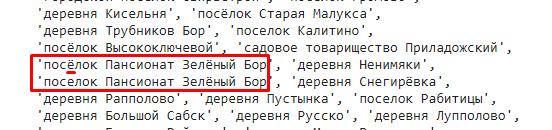

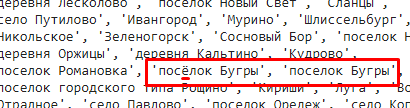

In [24]:
df['locality_name'] = df['locality_name'].str.replace('ё','е')

In [25]:
df['locality_name'].nunique()

330

В рамках нашей задачи требуются провести исследования по Санкт-Петербургу и 10 населённым пунктам с наибольшим количеством объявлений.

In [26]:
t = (
    df.groupby('locality_name',as_index=False)
    ['locality_name'].agg(['first','count']).
    sort_values('count',ascending=False).
    reset_index(drop=True)
)

In [27]:
t = t.rename(columns={'first':'locality_name'})

In [28]:
t.head(11)

,locality_name,count
0,Санкт-Петербург,15651
1,поселок Мурино,552
2,поселок Шушары,439
3,Всеволожск,398
4,Пушкин,369
5,Колпино,338
6,поселок Парголово,327
7,Гатчина,307
8,деревня Кудрово,299
9,Выборг,237


- Проверю дубли без слов "посёлок" и "деревня"

In [29]:
len(df[df['locality_name'] == 'Мурино'])

34

In [30]:
len(df[df['locality_name'] == 'Шушары'])

0

In [31]:
len(df[df['locality_name'] == 'Кудрово'])

171

In [32]:
len(df[df['locality_name'] == 'Парголово'])

0

Заменю на короткие версии названий

In [33]:
df['locality_name'] = df['locality_name'].str.replace('поселок Мурино', 'Мурино')

In [34]:
df['locality_name'] = df['locality_name'].str.replace('деревня Кудрово', 'Кудрово')

In [35]:
t = (
    df.groupby('locality_name',as_index=False)
    ['locality_name'].agg(['first','count']).
    sort_values('count',ascending=False).
    reset_index(drop=True)
)

In [36]:
t = t.rename(columns={'first':'locality_name'})

In [37]:
t.head(11)

,locality_name,count
0,Санкт-Петербург,15651
1,Мурино,586
2,Кудрово,470
3,поселок Шушары,439
4,Всеволожск,398
5,Пушкин,369
6,Колпино,338
7,поселок Парголово,327
8,Гатчина,307
9,Выборг,237


Остальные посёлки, деревни, посёлки городского типа и т.д. трогать не будем, поскольку в данном исследования нам это никак не поможет.

---

В столбце `ceiling_height` у нас почти 40% пропусков. Но мы можем их заполнить достаточно достоверно для решения поставленной задачи. Сделаем выборку из df, в которой будут только заполненные значения.

In [38]:
ceiling_available = df[~df['ceiling_height'].isna()]

Группируем по этажу и максимальной этажности (тип дома и соответствующих высот потолков в большинстве случаев).

In [39]:
#медианные значения для квартир на одинаковых этажах.
#в домах одинаковой этажности из выборки, где присутствуют все высоты потолков
ceiling_available.pivot_table(
    index='floor',
    columns='floors_total',
    values='ceiling_height',
    aggfunc='median'
).fillna('-')

floors_total,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,26.0,27.0,28.0,29.0,34.0,35.0,36.0,37.0,52.0,60.0
floor,,,,,,,,,,,,,,,,,,,,,
1,2.8,2.7,2.75,2.87,2.55,2.9,2.7,2.7,2.55,2.6,...,2.6,2.55,-,-,-,-,-,-,-,-
2,-,2.72,2.8,3.0,2.55,3.0,2.96,2.8,2.55,2.65,...,2.58,-,-,-,-,-,-,-,-,-
3,-,-,2.8,3.0,2.55,3.2,3.0,2.875,2.55,2.65,...,-,2.8,-,-,-,2.6,-,-,-,-
4,-,-,-,3.0,2.56,3.15,3.0,3.0,2.55,2.65,...,2.645,2.7,2.775,-,-,2.8,-,-,-,2.88
5,-,-,-,-,2.55,3.0,3.0,2.76,2.55,2.6,...,2.6,2.725,-,-,-,-,-,1.75,-,-
6,-,-,-,-,-,3.0,3.0,2.825,2.535,2.6,...,2.75,2.75,-,-,-,-,-,-,-,-
7,-,-,-,-,-,-,3.0,2.9,2.55,2.6,...,-,2.725,-,-,-,-,-,-,-,-
8,-,-,-,-,-,-,-,3.0,2.55,2.6,...,2.7,2.735,-,-,-,-,-,-,-,-
9,-,-,-,-,-,-,-,-,2.55,2.6,...,2.6,-,-,-,-,-,-,-,-,-


Медианы по сгруппированным значениям используются неспроста: 
*  почти все значения записаны в x,xx формате, поэтому медиана будет либо такой же, как большинство значений, либо с отклонением в 0,005 , если значений чётное количество (из-за метода вычисления медианы).
* Судя по старым знакомым `2.55м` на большинстве этажей милых нашему сердцу панелек (5 и 9 этажей), полученной таблице можно верить. **Очевидно, Хрущёвки правят этим сегментом.**
* В свою очередь, в более современных многоэтажных домах высота потолков находится в районе 2,7 - 2,8м , в сталлинках (4 этажа) высота около 3м. 
* И данные, полученные как медиана пересечения высот по этажам и этажности здания (тип многоэтажки), достоверны для подстановки в пропущенные ячейки искомого датафрейма `df`

[Метод заполнения медианами по группам со stackoverflow.com](https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group)

In [40]:
df['ceiling_height'] = (
    df['ceiling_height'].fillna(
        df.groupby(['floor', 'floors_total'])
        ['ceiling_height'].transform('median')
    )
)

Проверим теперь как выглядит сводная таблица высот потолков для всего датасета (NaN-ы сразу заменим на '-').

In [41]:
df.pivot_table(
    index='floor',
    columns='floors_total',
    values='ceiling_height',
    aggfunc='median'
).fillna('-')

floors_total,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,26.0,27.0,28.0,29.0,34.0,35.0,36.0,37.0,52.0,60.0
floor,,,,,,,,,,,,,,,,,,,,,
1,2.8,2.7,2.75,2.87,2.55,2.9,2.7,2.7,2.55,2.6,...,2.6,2.55,-,-,-,-,-,-,-,-
2,-,2.72,2.8,3.0,2.55,3.0,2.96,2.8,2.55,2.65,...,2.58,-,-,-,-,-,-,-,-,-
3,-,-,2.8,3.0,2.55,3.2,3.0,2.875,2.55,2.65,...,-,2.8,-,-,-,2.6,-,-,-,-
4,-,-,-,3.0,2.56,3.15,3.0,3.0,2.55,2.65,...,2.645,2.7,2.775,-,-,2.8,-,-,-,2.88
5,-,-,-,-,2.55,3.0,3.0,2.76,2.55,2.6,...,2.6,2.725,-,-,-,-,-,1.75,-,-
6,-,-,-,-,-,3.0,3.0,2.825,2.535,2.6,...,2.75,2.75,-,-,-,-,-,-,-,-
7,-,-,-,-,-,-,3.0,2.9,2.55,2.6,...,-,2.725,-,-,-,-,-,-,-,-
8,-,-,-,-,-,-,-,3.0,2.55,2.6,...,2.7,2.735,-,-,-,-,-,-,-,-
9,-,-,-,-,-,-,-,-,2.55,2.6,...,2.6,-,-,-,-,-,-,-,-,-


Медианные значения после заполнения пропусков не поменялись. Соответственно, пропуски были заполнены именно характерными значениями (по этажу и этажности здания).

Добавим метод `count` в сводную таблицу для оценки размера групп.

In [42]:
df.pivot_table(
    index='floor',
    columns='floors_total',
    values='ceiling_height',
    aggfunc='count'
).fillna('0')

floors_total,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,27.0,28.0,29.0,33.0,34.0,35.0,36.0,37.0,52.0,60.0
floor,,,,,,,,,,,,,,,,,,,,,
1,25.0,191.0,216.0,225.0,1100.0,115.0,60.0,30.0,467.0,126.0,...,5.0,0,0,0,0,0,0,0,0,0
2,0,190.0,218.0,351.0,1141.0,171.0,93.0,66.0,444.0,113.0,...,0.0,0.0,0,0,0,0,0,0,0,0
3,0,0,233.0,287.0,1107.0,150.0,75.0,64.0,430.0,114.0,...,4.0,0.0,0,0,0,3.0,0,0,0,0
4,0,0,0,330.0,1154.0,167.0,85.0,48.0,384.0,109.0,...,3.0,3.0,0,0,0,1.0,0,0,0,1.0
5,0,0,0,0,1273.0,160.0,84.0,44.0,420.0,117.0,...,7.0,0.0,0,0,0,0,0,1.0,0,0
6,0,0,0,0,0,147.0,103.0,38.0,372.0,123.0,...,2.0,0.0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,89.0,54.0,425.0,113.0,...,7.0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,44.0,422.0,110.0,...,5.0,0,0,0,0,0.0,0,0,0,0
9,0,0,0,0,0,0,0,0,394.0,131.0,...,0.0,0,0,0,0,0.0,0,0,0,0


In [43]:
# 0,2% пропусков осталось, поскольку некоторые пропуски уникальны по соотношению этаж-этажность и медиану для них брать неоткуда
df['ceiling_height'].isna().mean()

0.0019096117122851686

Хрущёвки и 9-этажные панельки преобладают, что соответствует действительности, потому что рынок вторичного жилья, объективно, намного больше, чем рынок новостроек (инфа 100%, работаю в отделе маркетинга крупного регионального застойщика).

Что касается размера групп и нерепрезентативности, то это не случай, поскольку отличия высот потолка в стандартизированных домах (на одинаковых этажах) отличаются на 3 - 5 см. Поэтому зная даже одно значение (этаж + тип дома), можно проставить такие же значения 100 другим записям при учёте дома такой же этажности и на том же этаже. И это не будет существенно искажать данные после заполнения пропусков.

Мы получим те же 2,55 для хрущёвок и 9-этажных панелек, 2,7 для новых многоэтажек и т.д.

Таблица медиан высот потолков по всей выборке после заполнения NaN-значений идентична той, которую мы получали для существующих изначально значений. Следовательно, заполнили верно, согласно этажу и типу дома.

**Откуда пропуски высот потолков вообще взялись в половине выборки?** 
Вероятнее всего, это небрежное заполнение данных пользователем. Если сделать поле с высотой потолка обязательным - NaN значений будет гораздо меньше. Вместо них появятся больше неточных и "взятых с потолка" значений.

**Проверим пропуски `kitchen_area` на соответствие True значений в `studio`.**

In [44]:
len(df[(df['kitchen_area'].isna()) & (df['studio'] == True)])

146

In [45]:
len(df[df['studio'] == True])

146

In [46]:
len(df[df['kitchen_area'].isna()])

2222

In [47]:
df['kitchen_area'].isna().sum()

2222

Понимаем, что пропуски тут не только из-за студий...

Проверим, может, ответ скрывается за открытыми планировками?

In [48]:
len(df[(df['kitchen_area'].isna()) & (df['open_plan'] == True)])

67

In [49]:
len(df[df['open_plan'] == True])

67

Таким образом, мы видим, что пропуски площади кухни - следствие не только открытых планировок и студий:

- Поскольку площадь кухни не является обязательным параметром в фиде Yandex Realty, то его просто проигнорировали, в тех случаях, когда это не студия или открытая планировка.

- Сам подготавливаю данные для формирования фидов и знаю, что информация о площади кухни нередко опускается, потому что в объявлении всегда должна быть схема планировки, где кухня и её площадь указана. 

**Оставим эти пропуски в покое, а для рассчёта соотношений жилой и общей площади, а также отношения площади кухни к общей используем те части выборки, где пропусков нет. При таком подходе, на мой взгляд, соотношение получится гораздо достоверней**



**Нам предстоит работать с датами, поэтому изменим тип данных в столбце `first_day_exposition` на datetime**

In [50]:
df['first_day_exposition'][2]

'2015-08-20T00:00:00'

In [51]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'],format='%Y-%m-%dT')

In [52]:
df['first_day_exposition'][2]

Timestamp('2015-08-20 00:00:00')

Данные об этажности имеют тип `float64`. Изменим на `int`, поскольку это дискретная величина и нам ничего не нужно хранить после запятой

In [53]:
df = df.astype({'floors_total': 'int8'})

In [54]:
df.rename(columns={'floor': 'level'}, inplace=True)

## Расчёты и добавление результатов в таблицу

Посчитаем цену квадратного метра.

При вычислении будем использовать `total_area`, поскольку при рассчёте цены используется именно общая площадь. Новый столец назовём `sqr_meter_price`

In [55]:
df['sqr_meter_price'] = df['last_price'] / df['total_area']

In [56]:
df['sqr_meter_price'].sample(2,random_state=1)

14194    238000.000000
1889      79032.258065
Name: sqr_meter_price, dtype: float64

- Избавимся от копеек

In [57]:
df['sqr_meter_price'] = df['sqr_meter_price'].round()

In [58]:
df['sqr_meter_price'].isna().mean()

0.0

**Добавим в датафрейм день недели, месяц и год публикации объявления. Возьмём их из даты публикации.**

In [59]:
df['day_of_week_expo'] = df['first_day_exposition'].dt.day_name()

In [60]:
df['month_expo'] = df['first_day_exposition'].to_numpy().astype('datetime64[M]')

In [61]:
df['year_expo'] = df['first_day_exposition'].to_numpy().astype('datetime64[Y]')

In [62]:
df[['first_day_exposition','day_of_week_expo','month_expo','year_expo']].sample(2,random_state=1)

,first_day_exposition,day_of_week_expo,month_expo,year_expo
14194,2019-03-31,Sunday,2019-03-01,2019-01-01
1889,2017-11-29,Wednesday,2017-11-01,2017-01-01


Присвоим категории в соответствии с этажом (первый, последний, другой) и внесём их в отдельный столбец, чтобы иметь возможность анализировать зависимость цены от этих параметров.


Напишем для этого простую логическую функцию. 

В качестве аргументов будем передавать строку датафрейма, из которой внутри функции будут сравниваться два значения: этаж и этажность здания. А ны выходе мы должны получать одно из трёх значений:
первый, последний, другой. 

Полученное значение будет присваиваться новой ячейке датафрейма в той же строке, по которой проводилось сравнение.

In [63]:
def floors_cat(row):
    """функция возвращает название этажной категории в зависимости от результата сравнения: 
    первый, последний, другой
    """
    level = row['level']
    floors_total = row['floors_total']
    if level == 1:
        return 'первый'
    if level == floors_total:
        return 'последний'
    return 'другой'

In [64]:
df['floors_category'] = df.apply(floors_cat, axis=1)

In [65]:
df[['floors_total','level','floors_category']].sample(10,random_state=2)

,floors_total,level,floors_category
16532,15,13,другой
12784,5,2,другой
6819,20,5,другой
1049,12,5,другой
12903,9,1,первый
13996,5,1,первый
23184,7,4,другой
11509,16,16,последний
15805,15,6,другой
12021,9,4,другой


Найдём и добавим соотношение жилой и общей площади, а также отношение площади кухни к общей.
Назовём новые столбцы согласно их содержания:

- `living/total`
- `kitchen/total`

In [66]:
df['living/total'] = round(df['living_area'] / df['total_area'], 2)

In [67]:
df['kitchen/total'] = round(df['kitchen_area'] / df['total_area'], 2)

In [68]:
df[['total_area','living_area','kitchen_area','living/total','kitchen/total']].head(2)

,total_area,living_area,kitchen_area,living/total,kitchen/total
0,108.0,51.0,25.0,0.47,0.23
1,40.4,18.6,11.0,0.46,0.27


## Исследовательский анализ данных

Изучим следующие параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы для каждого параметра.

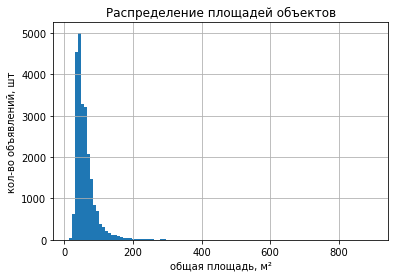

In [69]:
df['total_area'].hist(bins=100)
plt.title('Распределение площадей объектов')
plt.ylabel('кол-во объявлений, шт')
plt.xlabel('общая площадь, м²')
plt.show()

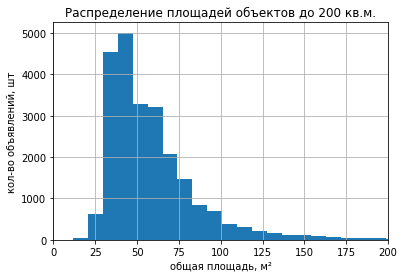

In [70]:
df['total_area'].hist(bins=100)
plt.title('Распределение площадей объектов до 200 кв.м.')
plt.xlim(0,200)
plt.ylabel('кол-во объявлений, шт')
plt.xlabel('общая площадь, м²')
plt.show()

Большая часть значений лежит в пределах 100 м².

**Вспомним данные таблицы по этажности зданий, в которой мы подсчитали количество объявлений по каждому этажу в доме определённой этажности:**

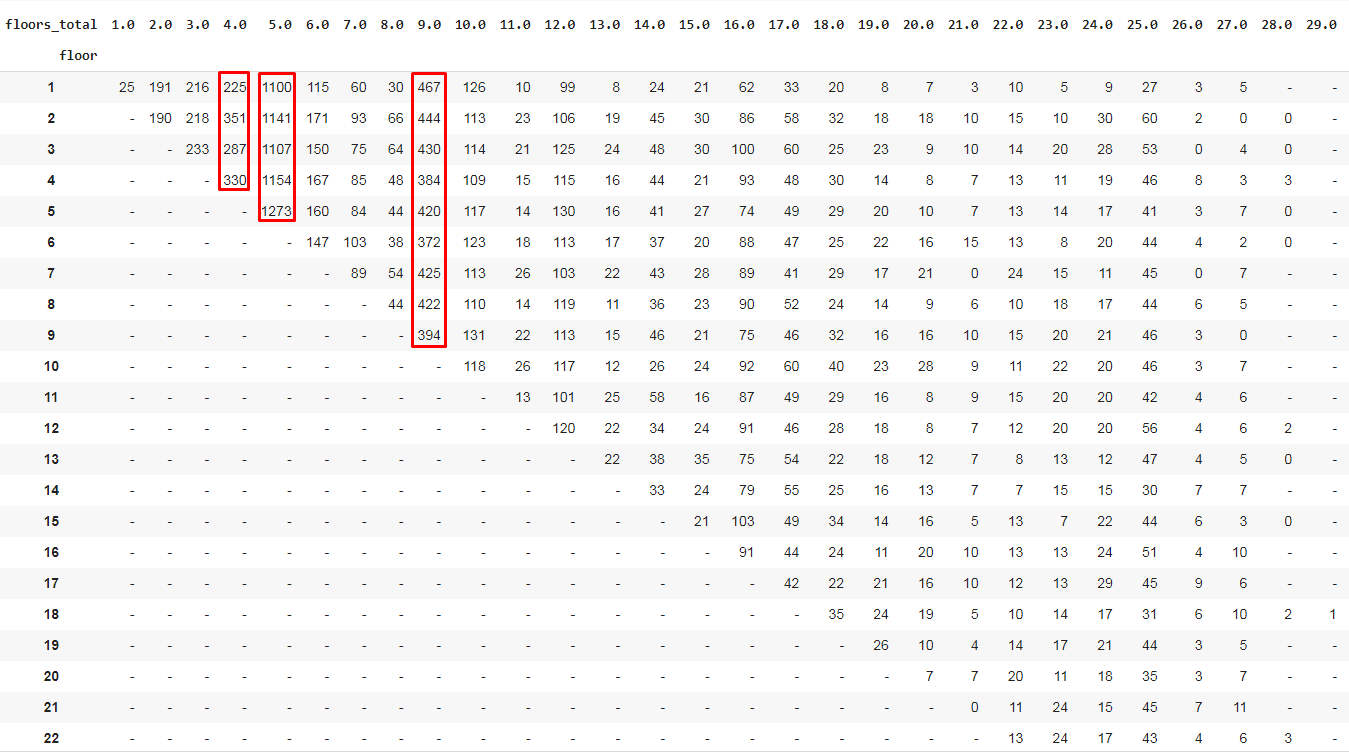

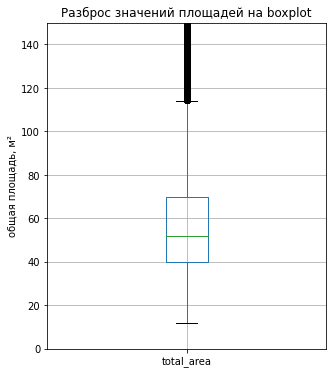

In [71]:
df.boxplot('total_area',figsize=(5,6))
plt.title('Разброс значений площадей на boxplot')
plt.ylim(0, 150)
plt.ylabel('общая площадь, м²')
plt.show()

In [72]:
df['total_area'].describe()

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

- Лидеры по числу объявлений - четырёх и пятиэтажки (хрущёвки), девятиэтажные дома брежневской эпохи. (таблица сверху)
- Как видим из описания разброса значений `df['total_area']` эти объявления  оказали существенное влияние на данные площади.
- Любопытства ради сложил пложадь типовых для таких домов двухкомнатной (44,1 м²) и трёхкомнатной квартир (61,4 м²) и разделил их надвое. Получилось 52,75 м², достаточно близко к нашей медиане.
- Но откуда же тогда взялись 900 м² в максимальном значении? Особенно при учёте, что 3-й квартиль равен 69,7 м². Посмотрим на "ящик с усами" и гдё, собственно, эти усы заканчиваются, чтобы определить где заканчиваются нормальные значения по версии диаграммы размаха.
- Также важно отметить, что среднее арифметическое превышает медиану только на 15%. Это говорит нам о том, что хоть максимум площади далеко за пределами привычных многим квартир, но таких значений относительно немного. Поэтому они не смогли сильно оттянуть на себя среднее арифметическое по выборке.

Из результатов вывода `desribe()` вычислим точное значение верхней границы нормальных значений. 

Для этого вопользуемся формулой: 1.5 * (Q3 - Q1) + Q3

1.5 * (69.7 - 40.0) + 69.7 = 114.25 м²

Всё, что больше, пока сочтём выбросом.

Нижняя граница нормальных значений на диаграмме размаха соответствует минимальному значению в наборе данных, 12 м²

Зная это, посмотрим на графическое отображение данных на гистограмме на верхней и нижней границах.

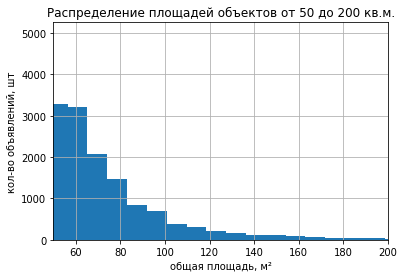

In [73]:
df['total_area'].hist(bins=100)
plt.title('Распределение площадей объектов от 50 до 200 кв.м.')
plt.xlim(50,200)
plt.ylabel('кол-во объявлений, шт')
plt.xlabel('общая площадь, м²')
plt.show()

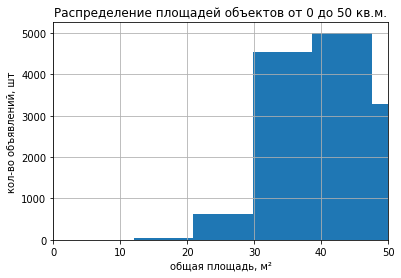

In [74]:
df['total_area'].hist(bins=100)
plt.title('Распределение площадей объектов от 0 до 50 кв.м.')
plt.xlim(0,50)
plt.ylabel('кол-во объявлений, шт')
plt.xlabel('общая площадь, м²')
plt.show()

Как видим, большая часть значений находится в пределах 100 м². Поэтому верхняя граница нормальных значений, равная 114,25 м², выглядит естесственно.

Также видим у нижней границы несколько характерных ступеней значений:
- до 21 м² вероятно, это комнаты в коммунальных квартирах.
- от 21 до 29,5 м² это студии.
- от 29,5 м² распространённые однокомнатные хрущёвки и однокомнатные квартиры в новостройках (изредка студии).

Несмотря на большое количество значений в выборке, форма гистограммы лишь отдалённо напоминает нормальное распределение (больше Пуассоновское,  но это не оно, поскольку площадь не распределена во времени). 

Она ступенчатая, и это ожидаемо, поскольку в большинстве случаев мы имеем дело с типовыми квартирами, которые отличаются друг от друга, в зависимости от комнатности, сразу на 10, 20 и т.д. метров. Отсюда и ступени на гистограмме.

Для изучения зависимости цены от площади возьмём часть выборки, лежащую в пределах `total_area` от 21 до 114,25 м².
Коммуналки отбросим, поскольку относительное колличество их несущественно. Проверим, есть ли среди них `studio == True`?

In [75]:
(df.query('total_area < 21 & studio == True')[['total_area','studio']].
sort_values(by='total_area').head(5))

,total_area,studio
8886,15.5,True
716,17.0,True
12996,18.0,True
8755,18.8,True
8454,19.0,True


In [76]:
(df[(df['total_area'] < 21) & (df['studio'] == True)]
[['total_area','studio']].
sort_values(by='total_area').head(5))

,total_area,studio
8886,15.5,True
716,17.0,True
12996,18.0,True
8755,18.8,True
8454,19.0,True


Как видно, встречаются студии площадью и менее 21 м².
Проверим, есть ли студии менее 15,5 м².

In [77]:
df.query('total_area < 15.5 & studio == True')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,level,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,sqr_meter_price,day_of_week_expo,month_expo,year_expo,floors_category,living/total,kitchen/total


Взглянем на объявления с площадью менее 15,5 м² без `studio`.

In [78]:
(df.query('total_area < 15.5').sort_values(by='total_area').head(10)
[['last_price','total_area','rooms','locality_name','studio']])

,last_price,total_area,rooms,locality_name,studio
19904,2400000.0,12.0,1,Санкт-Петербург,False
17961,1400000.0,13.0,1,Санкт-Петербург,False
19546,1850000.0,13.0,1,Санкт-Петербург,False
19807,3800000.0,13.0,1,Санкт-Петербург,False
19558,1686000.0,13.2,1,Санкт-Петербург,False
19642,1190000.0,14.0,1,Санкт-Петербург,False
12040,1900000.0,15.0,1,Сосновый Бор,False
16949,1550000.0,15.0,1,Санкт-Петербург,False


**Что узнали:**
- всего таких 8 значений.
- 7 из них в Санкт-Петербурге, то есть, вероятно, мы видим объявления о продаже комнат в комунальных квартирах, некоторые из которых даже имеют собственный кухонный уголок или санузел (есть данные о жилой площади, которая меньше общей)

**Как с этим быть:**
Ограничимся минимальной площадью известной нам студии для нижнего порога нормальных значений. То есть после данной проверки **для изучения зависимости цены от площади возьмём часть выборки, лежащую в пределах total_area от 15,5 до 114,25 м².**

**Цена. Исследуем множество значений `last_price`**

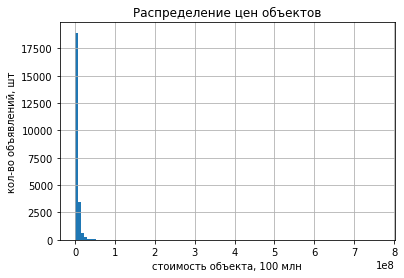

In [79]:
df['last_price'].hist(bins=100)
plt.title('Распределение цен объектов')
plt.ylabel('кол-во объявлений, шт')
plt.xlabel('стоимость объекта, 100 млн')
plt.show()

До 800 млн доходят значения  
Но не очень информативно, посмотрим на числовое описание распределения

In [80]:
df['last_price'].describe().map('{:.2f}'.format)

count        23565.00
mean       6540058.26
std       10910934.72
min          12190.00
25%        3400000.00
50%        4646000.00
75%        6790000.00
max      763000000.00
Name: last_price, dtype: object

Из результатов вывода `desribe()` вычислим точное значение верхней границы нормальных (по версии `boxplot`) значений:

1.5 * (Q3 - Q1) + Q3

* Верхняя граница: 1.5 * (6790000 - 3400000) + 6970000 = 11875000

* Нижняя граница равна минимуму выборки: 12190

Всё, что больше или меньше пока считается выбросом.

Зная это, посмотрим на графическое отображение данных на гистограмме в интересующих нас координатах.

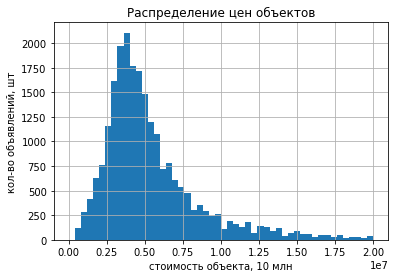

In [81]:
df['last_price'].hist(bins=50,range=(12190,20000000))
plt.title('Распределение цен объектов')
plt.ylabel('кол-во объявлений, шт')
plt.xlabel('стоимость объекта, 10 млн')
plt.show()

После 11875000 ₽ есть длинный хвост, но значений относительно мало. Чтобы посмотреть на отдельные значения построим на сырых данных `df` график разброса значений (цены от площади).

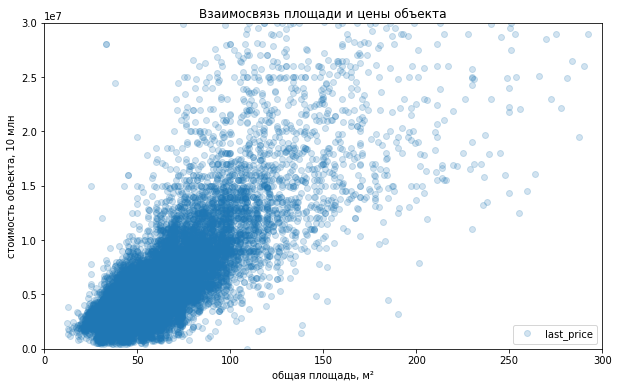

In [82]:
df.plot(
    x='total_area',
    y='last_price',
    style='o',
    alpha=0.2,
    figsize=(10,6),
    ylim=(0,30000000),
    xlim=(0,300)
)
plt.title('Взаимосвязь площади и цены объекта')
plt.ylabel('стоимость объекта, 10 млн')
plt.xlabel('общая площадь, м²')
plt.show()

Граница нормальных значений в 11,875 млн просматривается на графике (точки уже не так плотно расположены), но после неё ещё до 15 млн наблюдается большое количество значений. Да и цена в 15 млн для Санкт-Петербурга - не редкость.

**Верхнюю границу нормальных значений установим на 15 млн ₽**

Рассмотрим ближе нижнюю границу от `0` до `2` млн.

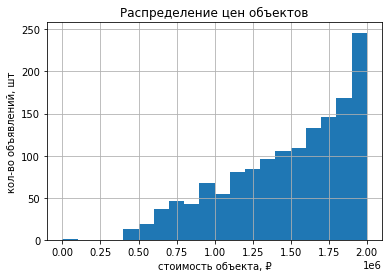

In [83]:
df['last_price'].hist(bins=20,range=(0, 2000000))
plt.title('Распределение цен объектов')
plt.xlabel('стоимость объекта, ₽')
plt.ylabel('кол-во объявлений, шт')
plt.show()

Минимальное значение 12190 ₽ выглядит как выброс. А значения, похожие на нормальные, начинаются ближе к 0,5 млн.

Посмотрим на объявление с минимальным и ближайшим к нему значениям `last_price`

In [84]:
(df.query('last_price < 500000')
[['last_price','sqr_meter_price','total_area','floors_total','level','living_area','kitchen_area','locality_name',]]
.sort_values(by='last_price').head(5))

,last_price,sqr_meter_price,total_area,floors_total,level,living_area,kitchen_area,locality_name
8793,12190.0,112.0,109.0,25,25,32.0,40.5,Санкт-Петербург
14911,430000.0,7963.0,54.0,3,3,NaN,NaN,поселок станции Свирь
17456,430000.0,14145.0,30.4,2,1,16.0,6.0,Сланцы
16274,440000.0,11000.0,40.0,5,1,NaN,NaN,деревня Старополье
5698,450000.0,10714.0,42.0,1,1,23.0,5.8,городской поселок Будогощь


Тут очевидная ошибка в цене. Не хватает как минимум трёх нулей. Потому что это, вероятнее всего, квартира с террасой по следующим признакам:
- общая площадь существенно больше суммы площадей кухни и жилой площади.
- последний этаж.

Последующие объявления не вызывают сомнений, особенно если вбить названия населённых пунктов в Yandex карты и посмотреть на локации.

**Поэтому нижней границей нормальных значений `last_price` примем 430000₽.**

Проверим квартиры стоимостью ниже 1 млн на наличие там объявлений из Санкт-Петербурга, чтобы избежать такие ошибки в цене.

In [85]:
df[(df['last_price'] < 1000000) & (df['locality_name'] == "Санкт-Петербург")]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,level,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,sqr_meter_price,day_of_week_expo,month_expo,year_expo,floors_category,living/total,kitchen/total
8793,7,12190.0,109.0,2019-03-20,2,2.75,25,32.0,25,False,...,0.0,NaN,8.0,112.0,Wednesday,2019-03-01,2019-01-01,последний,0.29,0.37


Только одно, которое мы уже зафиксировали.

Чтобы не отбрасывать максимум и соседние с ним значения только по результатам вывода `decribe`, изучим поближе эти объявления.

In [86]:
df.query('last_price == 763000000.00')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,level,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,sqr_meter_price,day_of_week_expo,month_expo,year_expo,floors_category,living/total,kitchen/total
12971,19,763000000.0,400.0,2017-09-30,7,2.6,10,250.0,10,False,...,3.0,756.0,33.0,1907500.0,Saturday,2017-09-01,2017-01-01,последний,0.62,NaN


Вероятно, тут мы имеем дело с пентхаусом:
- последний этаж
- огромная площадь
- 7 комнат
- только потолки подозрительно низкие. Вернувщись к исходной версии данных, обнаружил, что там был пропуск в высоте потолка. А в силу того, что этажность здания попала в выборку с множеством объявлений стандартных квартир в 10-этажках, на место пропуска встала медиана, характерная для стандартной недвижимости. Согласен, метод заполнения не идеален, но с остальным большинством он сработал как надо.
- судя по цене и этажности, это премиальная недвижимость

Правильно поступили, что отбросили это значение. Теперь посмотрим на соседние с ним по цене объявления.

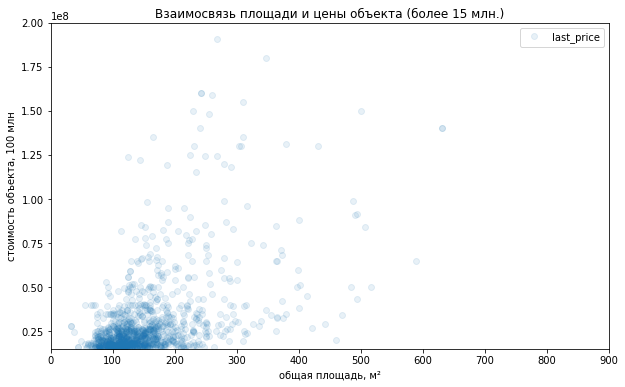

In [87]:
df.query('last_price > 15000000').plot(
    x='total_area',
    y='last_price',
    style='o',
    alpha=0.1,
    figsize=(10,6),
    ylim=(15000000,200000000),
    xlim=(0,900)
)
plt.title('Взаимосвязь площади и цены объекта (более 15 млн.)')
plt.ylabel('стоимость объекта, 100 млн')
plt.xlabel('общая площадь, м²')
plt.show()

Относительно немного объявлений, колоссальный разброс цен у квартир с похожей площадью (дельта на графике до 175 млн для одинаковых площадей). Что характерно для элитной и нестандартной недвижимости, которую мы оставили за пределами нормальных значений `last_price`.

Проверим локации, в которых находятся эти объекты недвижимости.

In [88]:
df[df['last_price'] > 15000000]['locality_name'].value_counts()

Санкт-Петербург     1158
Пушкин                18
Сестрорецк             6
Петергоф               2
поселок Стрельна       2
Зеленогорск            2
Красное Село           1
поселок Репино         1
Выборг                 1
Кронштадт              1
Колпино                1
деревня Бор            1
Всеволожск             1
Name: locality_name, dtype: int64

Как я и предполагал, большинство объявлений из Петербурга. Есть хвост из деревень и посёлков, в которых с помошью Yandex можно легко отыскать элитную недвижимость. Поэтому совершенно справедливо оставляем эти значения за рамками нормальных значений. Это особенная недвижимость, требующая особенного подхода и более тщательного сбора данных.

Таким образом границы нормальных значений цены в нашей выборке определим такие:
- **430000 ₽**
- **15000000 ₽**

**Число комнат. Исследуем множество значений `rooms`.**

In [89]:
df['rooms'].describe()

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Минимальное значение комнатности 0, что странно на первый взгляд. 

Посмотрим сколько таких объявлений и какие это объявления.

In [90]:
df.query('rooms == 0').sample(5,random_state=1)[['total_area','open_plan','studio']]

,total_area,open_plan,studio
5074,28.0,False,True
21299,28.5,True,False
20054,21.0,True,False
3896,26.0,False,True
17582,22.0,False,True


Что примечательно, это либо студия, либо открытая планировка.

Посмотрим, сколько всего объявлений с 0 комнат.

In [91]:
len(df.query('rooms == 0'))

194

In [92]:
len(df.query('rooms == 0 & studio == True'))

135

Итак, 135 объявлений с 0 комнат - это студии.
Посмотрим на оставшиеся 59 (всего 194 с 0 комнат)

In [93]:
df.query('rooms == 0 & studio == False').head()[['rooms','studio','open_plan']]

,rooms,studio,open_plan
349,0,False,True
508,0,False,True
780,0,False,True
839,0,False,True
946,0,False,True


Проверим, все ли оставшиеся в выборке `rooms == 0` квартиры с открытой планировкой (`open_plan == True`).

In [94]:
df.query('studio == False & rooms == 0')['open_plan'].mean()

1.0

In [95]:
len(df.query('rooms == 0 & open_plan == True'))

59

Из 194 объявлений с 0 комнат:
- 135 студий,
- 59 открытых планировок

**Возникает вопрос: сколько всего студий и открытых планировок в df и какие значения комнаности в остальных объявлениях c ненулевой комнатностью ?**

In [96]:
len(df.query('studio == True'))

146

In [97]:
df.query('rooms > 0 & studio == True')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,level,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,sqr_meter_price,day_of_week_expo,month_expo,year_expo,floors_category,living/total,kitchen/total
2389,5,2250000.0,25.41,2016-06-07,1,2.650,12,17.08,8,False,...,2.0,485.0,26.0,88548.0,Tuesday,2016-06-01,2016-01-01,другой,0.67,NaN
3187,13,3800000.0,27.00,2016-05-17,1,2.605,14,18.00,8,False,...,0.0,NaN,45.0,140741.0,Tuesday,2016-05-01,2016-01-01,другой,0.67,NaN
4180,4,4500000.0,34.00,2016-04-25,1,2.800,10,21.00,10,False,...,1.0,433.0,62.0,132353.0,Monday,2016-04-01,2016-01-01,последний,0.62,NaN
8683,10,3500000.0,32.50,2016-05-05,1,3.000,23,29.90,11,False,...,1.0,564.0,45.0,107692.0,Thursday,2016-05-01,2016-01-01,другой,0.92,NaN
11026,1,2800000.0,28.00,2016-05-04,1,2.750,26,19.00,6,False,...,0.0,NaN,45.0,100000.0,Wednesday,2016-05-01,2016-01-01,другой,0.68,NaN
12935,10,2200000.0,31.00,2016-05-15,1,2.500,8,22.30,5,False,...,NaN,NaN,44.0,70968.0,Sunday,2016-05-01,2016-01-01,другой,0.72,NaN
15142,2,2700000.0,30.00,2016-05-10,1,2.700,21,26.00,6,False,...,NaN,NaN,55.0,90000.0,Tuesday,2016-05-01,2016-01-01,другой,0.87,NaN
18732,4,2400000.0,22.00,2016-05-06,1,2.600,10,15.00,6,False,...,NaN,NaN,45.0,109091.0,Friday,2016-05-01,2016-01-01,другой,0.68,NaN
20086,0,1550000.0,22.00,2016-05-11,1,2.700,15,10.94,14,False,...,NaN,NaN,45.0,70455.0,Wednesday,2016-05-01,2016-01-01,другой,0.50,NaN
21702,9,2349000.0,23.40,2016-05-19,1,2.700,20,16.00,8,False,...,NaN,NaN,34.0,100385.0,Thursday,2016-05-01,2016-01-01,другой,0.68,NaN


Всё-таки логичнее считать, что в студии одна комната есть. Заменим 0 в остальных объявлениях на 1.

In [98]:
df.loc[(df['rooms'] == 0) & (df['studio'] == True), 'rooms'] = 1

In [99]:
len(df.query('rooms == 0 & studio == True'))

0

Теперь рассмотрим объявления с открытыми планировками:

- сколько всего.
- какие значения комнатности стоят в объявлениях с ненулевым значением.

In [100]:
len(df.query('open_plan == True'))

67

In [101]:
df.query('rooms > 0 & open_plan == True')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,level,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,sqr_meter_price,day_of_week_expo,month_expo,year_expo,floors_category,living/total,kitchen/total
1379,3,6000000.0,44.2,2015-11-10,1,2.70,25,17.4,23,False,...,0.0,NaN,231.0,135747.0,Tuesday,2015-11-01,2015-01-01,другой,0.39,NaN
5668,9,3550000.0,36.7,2016-04-25,1,2.75,16,17.8,2,False,...,NaN,NaN,61.0,96730.0,Monday,2016-04-01,2016-01-01,другой,0.49,NaN
8861,13,5500000.0,64.5,2015-11-13,3,3.00,5,48.0,2,False,...,2.0,204.0,229.0,85271.0,Friday,2015-11-01,2015-01-01,другой,0.74,NaN
9063,6,3800000.0,39.0,2016-05-19,1,2.70,17,30.0,1,False,...,0.0,NaN,45.0,97436.0,Thursday,2016-05-01,2016-01-01,первый,0.77,NaN
12760,0,3350000.0,51.0,2015-01-22,2,2.50,12,30.0,10,False,...,NaN,NaN,521.0,65686.0,Thursday,2015-01-01,2015-01-01,другой,0.59,NaN
14017,13,3990000.0,59.0,2016-03-29,3,2.50,9,37.6,3,False,...,1.0,705.0,81.0,67627.0,Tuesday,2016-03-01,2016-01-01,другой,0.64,NaN
17783,3,48763000.0,157.0,2016-04-01,5,2.80,11,NaN,5,False,...,3.0,221.0,90.0,310592.0,Friday,2016-04-01,2016-01-01,другой,NaN,NaN
19796,1,12000000.0,97.2,2016-04-05,4,3.35,5,71.3,2,False,...,0.0,NaN,89.0,123457.0,Tuesday,2016-04-01,2016-01-01,другой,0.73,NaN


У нас 8 объявлений с открытой планировкой, разным количеством комнат, и что примечательно, разной площадью.

Причём соотношение площади и количества комнат аналогичны обычным квартирам (без открытой планировки).

Но заполнять 59 нулевых значений комнатности на основе имеющихся 8 в данном случае больше похоже на гадание. 

Поэтому справедливо будет не искажать выборку по комнатности, заполняя эти данные. А нижней границей нормальных значений возьмём значение комнатности **1** без замены нулей в объявлениях с открытой планировкой.

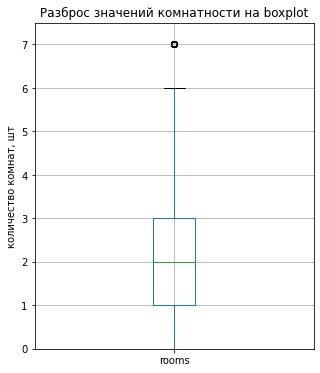

In [102]:
df.boxplot('rooms',figsize=(5,6))
plt.title('Разброс значений комнатности на boxplot')
plt.ylim(0, 7.5)
plt.ylabel('количество комнат, шт')
plt.show()

Верхняя граница нормальных значений судя по ящику с усами равна 6.

Посмотрим на гистограмму множества значений `rooms` и скорректируем её при необходоимости.

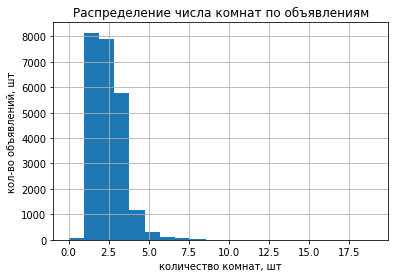

In [103]:
df['rooms'].hist(bins=20)
plt.title('Распределение числа комнат по объявлениям')
plt.xlabel('количество комнат, шт')
plt.ylabel('кол-во объявлений, шт')
plt.show()

Не очень информативно, особенно зная, что у нас дискретные значения от 1 до 19.

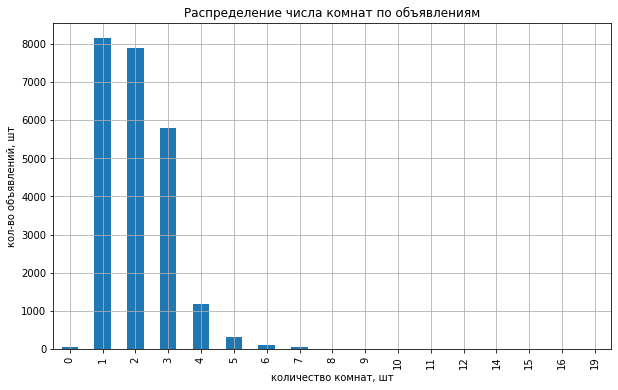

In [104]:
df.groupby('rooms')['rooms'].count().plot(
    kind='bar', 
    x='rooms', 
    figsize=(10,6), 
    grid=True
)
plt.title('Распределение числа комнат по объявлениям')
plt.xlabel('количество комнат, шт')
plt.ylabel('кол-во объявлений, шт')
plt.show()

Так намного информативней. Очевидно, что 5,6,7-комнатных квартир совсем немного. Посомотрим на их общее количество и разброс цен.
Разброс цен в данной ситуации нас интересует потому, что такие квартиры являются большой редкостью и эксклюзивом, поэтому критерии влияющие на цены таких объектов могут сильно отличаться в каждом конкретном случае.

In [105]:
df.query('rooms > 4')['last_price'].describe().map('{:.2f}'.format)

count          519.00
mean      30233188.17
std       52038542.33
min        1650000.00
25%       11500000.00
50%       16500000.00
75%       29000000.00
max      763000000.00
Name: last_price, dtype: object

Как видно, объявлений квартир c более чем 4 комнатами относительно мало, а разброс цен в них значительный. Стандартное отклонение превышает медиану в 3 раза, максимум больше минимума в 462 раза. Поэтому при оценке зависимости цены от комнатности мы используем бОльшую часть выборки, содержащую в себе значения от 1 до 4 комнат.

**Высота потолков. Исследуем множество значений `ceiling_height`.**

In [106]:
df['ceiling_height'].describe()

count    23520.000000
mean         2.735668
std          0.995016
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64

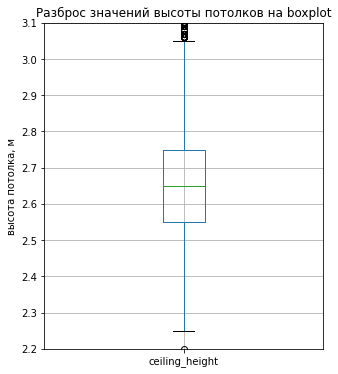

In [107]:
df.boxplot('ceiling_height', figsize=(5,6))
plt.title('Разброс значений высоты потолков на boxplot')
plt.ylim(2.2, 3.1)
plt.ylabel('высота потолка, м')
plt.show()

Большая часть значений (3й квартиль) до 3м. 100-метровый потолок - явный выброс.
Границы нормальных значений пока примем 2,25(вероятно, цокольные этажи) и 3,05 м.
Но мы знаем, что в СПБ легко могут встречаться квартиры и с потолками 4 метра.
Посмотрим на гистаграмму значений.

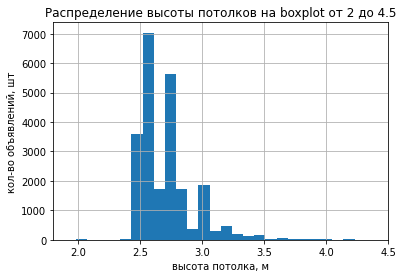

In [108]:
df['ceiling_height'].hist(bins=50,range=(0, 4.5))
plt.title('Распределение высоты потолков на boxplot от 2 до 4.5')
plt.xlim(1.8, 4.5)
plt.ylabel('кол-во объявлений, шт')
plt.xlabel('высота потолка, м')
plt.show()

Видно три явных пика на уровнях самых распространённых значений высот: 2.55 , 2.7 , 3.0

После небольшого пика на 3.2 м объявлений совсем немного. 

Стоит отметить, что на верхних этажах современных ЖК комфорт и бизнесс класса высота потолков нередко бывает 3,2 м, поэтому повысим границу нормальных значений до 3,2 м

2,25 м крайне мало значений в наборе данных, чтобы учитывать его. Поэтому границы нормальных значений высот потолка в данной выборке: 2,5 - 3,2м

In [109]:
len(df.query('ceiling_height <= 3.2 & ceiling_height >= 2.5')) / len(df)

0.9604073838319541

Рассмотрим высоты потолков, начиная с максимальной.

In [110]:
(df.query('ceiling_height > 3.2')
.sort_values(by='ceiling_height',ascending=False)
['ceiling_height'].head(5))

22869    100.0
3148      32.0
22336     32.0
21377     27.5
22938     27.0
Name: ceiling_height, dtype: float64

In [111]:
df.query('ceiling_height > 4')['ceiling_height'].sample(5,random_state=1)

4892      4.10
17442     8.00
2823      4.50
22309    10.30
17078     4.25
Name: ceiling_height, dtype: float64

Если максимальное значение `ceiling_height` в 100м выглядит как ошибка значения, то следующие за ней похоже на ошибку порядка: если уменьшить число на один порядок, то мы получим знакомые высоты потолков 3.2, 2.75, 2.70.

Однако, если мы продолжим дальше просматривать значения `ceiling_height`, то по пути к верхней границе нормального распределения встретим и 10 и 8 метров, которые как "промах с запятой" не квалифицируешь.

**Поэтому границами нормальных значений высот потолка в выборке df будем считать (2,5 : 3,20).**

In [112]:
(df.query('ceiling_height <= 3.2 & ceiling_height >= 2.5')
['ceiling_height'].describe())

count    22632.000000
mean         2.679935
std          0.167358
min          2.500000
25%          2.550000
50%          2.650000
75%          2.750000
max          3.200000
Name: ceiling_height, dtype: float64

Эти значения уже больше похожи на разброс имеено высот потолков многоквартирных домов, а не ангаров и технических этажей или роскошных вилл.

**Изучим время продажи квартиры `days_exposition`**

In [113]:
df['days_exposition'].describe()

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее значение почти в 2 раза больше медианы. Стоит ожидать длинный хвост больших значений, как это было в задаче с заправками. Посмотрим на гистограмму.

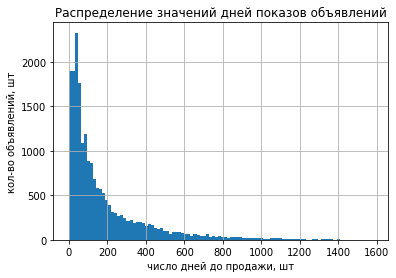

In [114]:
df.hist('days_exposition',bins=100,range=(0,1580))
plt.title('Распределение значений дней показов объявлений')
plt.xlabel('число дней до продажи, шт')
plt.ylabel('кол-во объявлений, шт')
plt.show()

Гистограмма даёт нам понять, что в течение 300 дней большинство объектов недвижимости продаётся.

А половина объектов продаётся в течение первых трёх месяцев. Если смотреть по выбрке, то среднее время продаж квартиры - пол года.

Также очевидно, что сразу после размещения продажи происходят гораздо автивнее. И со временем, те объекты, которые не попались потенциальным покупателям на старте своего размещения,  продаются всё реже и реже.

Посмотрим на границы распредения (в нашем случае - Пуассона) на диаграмме размаха.

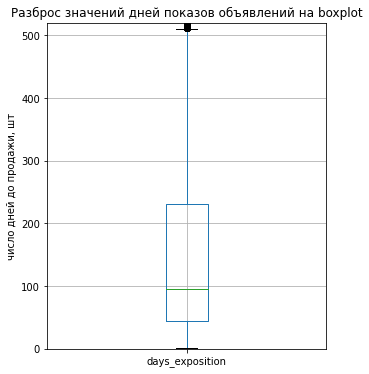

In [115]:
df.boxplot('days_exposition',figsize=(5,6))
plt.title('Разброс значений дней показов объявлений на boxplot')
plt.ylim(0, 520)
plt.ylabel('число дней до продажи, шт')
plt.show()

Диаграмма размаха указывает на границы нормальных значений для данной выборки:

- минимальное 1 день
- максимальное 510 дней.

Посмотрим на гистограмму в этих пределах.

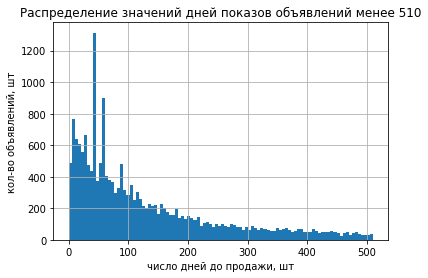

In [116]:
df.query('days_exposition < 510').hist('days_exposition',bins=100,range=(0,510))
plt.title('Распределение значений дней показов объявлений менее 510')
plt.xlabel('число дней до продажи, шт')
plt.ylabel('кол-во объявлений, шт')
plt.show()

Итак, у нас 2 явных мощных пика около 40 и 60 дней. Рассмотрим их ближе и найдём точные значения `days_exposition`, с которыми объявлений было существенно больше, чем с соседними значениями.


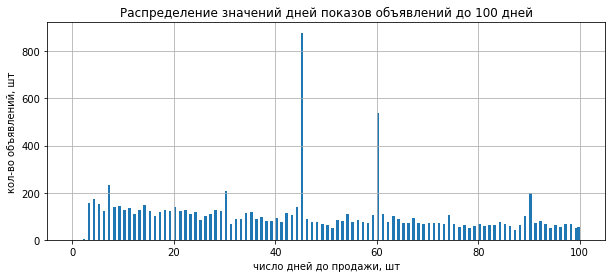

In [117]:
df.hist('days_exposition',bins=200,range=(0,100),figsize=(10,4))
plt.title('Распределение значений дней показов объявлений до 100 дней')
plt.xlabel('число дней до продажи, шт')
plt.ylabel('кол-во объявлений, шт')
plt.show()

**Судя по нижней границе значений `days_exposition` очень быстрыми можно считать продажи, которые произошли в 1-ый и 2-ой день. Поскольку они очень редки, как видно из гистограммы.**

**Необычно долгими продажами можно считать те, которые расположены за 3-м квартилем значений `days_exposition` (231 день), потому что на диаграме размаха мы наблюдаем сильное смещение медианы в меньшую сторону и максимальный размер верхнего "уса"**

Проверим наверняка, каким значениям принадлежат пики на графиках

In [118]:
df.query('days_exposition < 100')['days_exposition'].value_counts().head(10)

45.0    879
60.0    538
7.0     234
30.0    208
90.0    200
4.0     174
3.0     157
5.0     152
14.0    147
9.0     142
Name: days_exposition, dtype: int64

Количество объявлений, снятых с показа (продажи, но не исключаем и другие причины) в несколько раз превосходит среднее арифметическое выборки.

Начнём с самой ужасной гипотезы: сбой на платфороме, снятие с показа множества объявлений. Тогда дата размещения у них должна быть одинаковая.

In [119]:
df[df['days_exposition']==45.0]['first_day_exposition'].value_counts().head(10)

Series([], Name: first_day_exposition, dtype: int64)

Но мы же только что видели, что объявлений с `days_exposition == 45.0` 879 штук. Не исключено, что это издержки типа данных `float`. Но в `int` я осознанно отказался переводить данный столбец, потому что это требовало заполнения пропусков, что изменило бы достоверность данных о снятии с публикации (продаже). Поэтому выкрутился округлением до `0` знаков после запятой.

In [120]:
df['days_exposition'] = df['days_exposition'].round(decimals=0)

In [121]:
df.query('days_exposition == 45.0')['first_day_exposition'].value_counts()

2018-02-07    15
2017-12-09    13
2017-12-07    12
2018-01-11    12
2018-01-12    11
              ..
2017-08-20     1
2017-05-08     1
2018-07-07     1
2017-05-28     1
2017-07-19     1
Name: first_day_exposition, Length: 409, dtype: int64

In [122]:
df.query('days_exposition == 60.0')['first_day_exposition'].value_counts()

2017-11-10    12
2017-12-18    11
2017-11-11     6
2017-12-14     6
2018-07-17     6
              ..
2017-01-25     1
2017-04-18     1
2018-07-26     1
2018-08-15     1
2018-10-26     1
Name: first_day_exposition, Length: 309, dtype: int64

Много разных дат публикации. Стало быть, не однодневный предполагаемый сбой выключил так много объявлений, а на 45-й и 60-й день размещения объявления получают дополнительный охват, ранее им недоступный. 

Это могло быть премиальное размещение в верхней части поисковой выдачи сервиса, на главной старнице или же на других плейсментах, обладающих более высокой конверсией, нежели стандартное размещение на Yandex Realty.

**Так или иначе, объявления с `days_exposition` равным 45.0 и 60.0 очень сильно выбиваются из всего набора данных. Для понимания причин таких всплесков нам понадобятся дополнительные сведения от технических специалистов платформы. При оценке любой зависимости от даты размещения не будем их использовать.**


**Изучим зависимсти цены от:**
1. площади
2. число комнат
3. удалённость от центра
4. этаж (3 категории)
5. дата размещения: день, месяц, год.


**1. Зависимость цены от площади**

In [123]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'level',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'sqr_meter_price',
       'day_of_week_expo', 'month_expo', 'year_expo', 'floors_category',
       'living/total', 'kitchen/total'],
      dtype='object')

**Сделаем датафрейм, учитывающий границы нормальных значений, найденные ранее.**

In [124]:
df_norm = df.query((
    'last_price >= 430000 &' 
    'last_price <= 15000000 &' 
    'total_area >= 15.5 &'
    'total_area <= 114.25 &' 
    'rooms >=1 &'
    'rooms <= 4 &'
    'ceiling_height >= 2.5 &'
    'ceiling_height <= 3.2 &'
    'days_exposition != 45.0 &' 
    'days_exposition != 60.0'
)).copy()

In [125]:
df_norm.shape

(19863, 29)

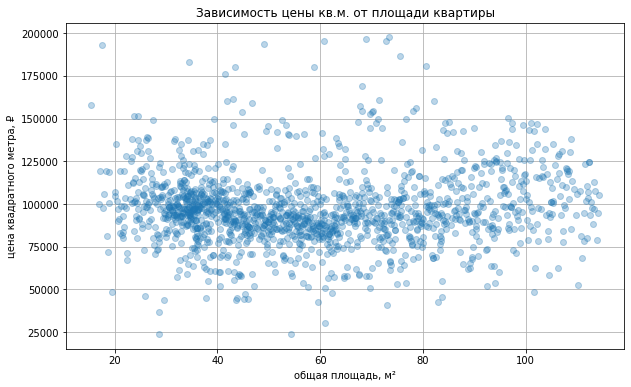

In [126]:
(df_norm.groupby('total_area')['sqr_meter_price']
.median()
.plot(
    x='total_area',
    y='sqr_meter_price',
    style='o',
    figsize=(10,6),
    grid=True,
    alpha=0.3
))
plt.title('Зависимость цены кв.м. от площади квартиры')
plt.xlabel('общая площадь, м²')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

- На графике видно, что квартиры с меньшей площадью (студии, однокомнатные) чаще имеют более высокую цену квадратного метра, чем 2х,3х,4х-комнатные квартиры такого же класса. Это соответствует реальному положению дел на рынке недвижимости.
- также очень редки значения выше 130000 ₽. Если такая цена не обусловлена дополнительными инфраструктурными преимуществами (закрытая территория, охраняемый двор или какой-нибудь автомобильный лифт), **то вероятнее всего, цена завышена, на что следует обращать внимание службы модерации объявлений.**

**2. Зависимость цены от числа комнат**

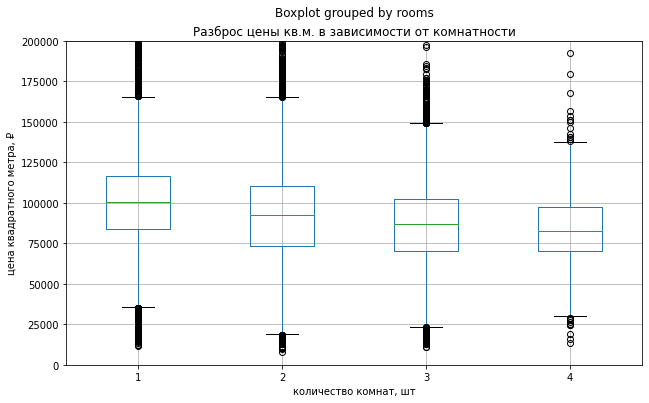

In [127]:
df_norm.boxplot(
    'sqr_meter_price', 
    by='rooms', 
    figsize=(10,6)
)
plt.ylim(0,200000)
plt.title('Разброс цены кв.м. в зависимости от комнатности')
plt.xlabel('количество комнат, шт')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

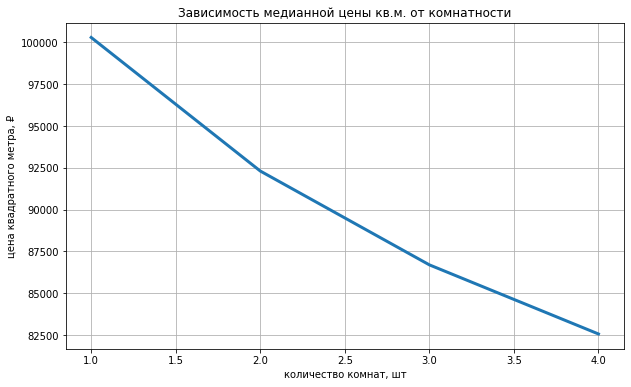

In [128]:
(df_norm.groupby('rooms')['sqr_meter_price']
.median()
.plot(
    x='rooms',
    y='sqr_meter_price',
    figsize=(10,6),
    grid=True,
    linewidth=3,
))
plt.title('Зависимость медианной цены кв.м. от комнатности')
plt.xlabel('количество комнат, шт')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

**Больше комнат - ниже цена квадратного метра, что мы заметили ещё на прошлом графике.**

**Но данная закономерность прослеживается только в случае типового жилья с комнатностью до 5. После 5 начинают действовать законы элитной недвижимости и цена квадратного метра начинает ползти вверх.**

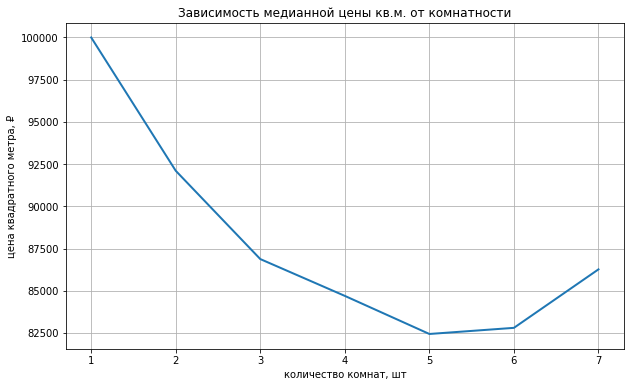

In [129]:
(df.query(
    'rooms >= 1 &'
    'rooms <= 19 &'
    'last_price >= 430000 &'
    'last_price <= 15000000'
).groupby('rooms')['sqr_meter_price']
.median()
.plot(
    x='rooms',
    y='sqr_meter_price',
    figsize=(10,6),
    grid=True,
    linewidth=2
))
plt.title('Зависимость медианной цены кв.м. от комнатности')
plt.xlabel('количество комнат, шт')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

**Зависимость цены от удалённости от центра (Санкт-Петербург)**

Остальные города в исследовании не используются, потому что там размер выборок мал.

In [130]:
#метры - в километры
df_norm['city_сenters_km'] = (df_norm['city_centers_nearest'] / 1000).round(decimals=0)

In [131]:
df_norm['city_сenters_km']

0        16.0
1        19.0
2        14.0
4         8.0
5         NaN
         ... 
23692     NaN
23693    34.0
23696     NaN
23697    10.0
23698     NaN
Name: city_сenters_km, Length: 19863, dtype: float64

- Возьмём СПБ, потому что остальные населённые пункты малы

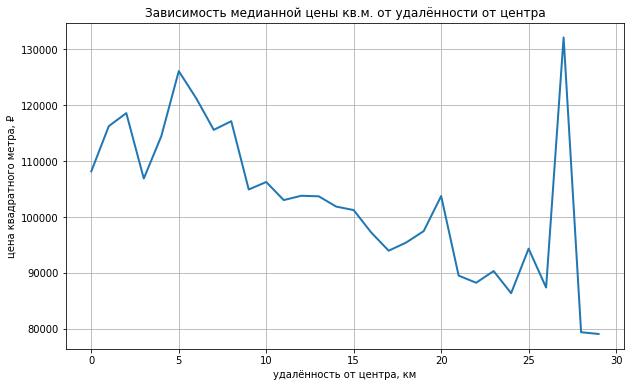

In [132]:
(df_norm.query('locality_name == "Санкт-Петербург"')
.groupby('city_сenters_km')['sqr_meter_price'].median()\
.plot(
    x='city_сenters_km',
    y='sqr_meter_price',
    figsize=(10,6),
    grid=True,
    linewidth=2
))
plt.title('Зависимость медианной цены кв.м. от удалённости от центра')
plt.xlabel('удалённость от центра, км')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

На значении в 2 км цена начинает стремительно падать, и если посмотрим на карту Санкт-Петербурга с центром на Дворцовой площади, то в окружности с радиусом в 2 км распологается большая часть исторического центра.

В центре не дёшево, но поскольку это СПБ - там в основном старый жилой фонд. Поэтому на 5 км удалении от центра, где как раз уже могут располагаться новые благоустроенные ЖК в более тихих районах, цена поднимается ещё немного выше. А 5 км для города с развитой транспортной инфраструктурой - расстояние небольшое, но достаточное для создания условий, описанных в предыдущем предложении.

На 20, 25 и 27км наблюдаются скачки средней цены кв. метра. Вероятнее всего, это недвижимость в тихой окраине города, где располоагаются более дорогостоящие элитные объекты, попавшие в выборку.

**Зависимость цены от этажа (3 категории).**

In [133]:
df_norm.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'level',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'sqr_meter_price',
       'day_of_week_expo', 'month_expo', 'year_expo', 'floors_category',
       'living/total', 'kitchen/total', 'city_сenters_km'],
      dtype='object')

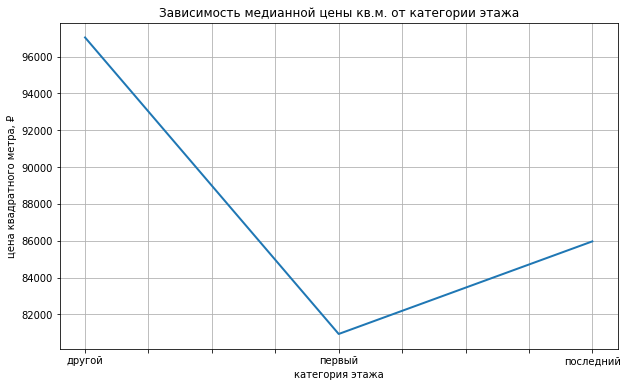

In [134]:
(df_norm.groupby('floors_category')['sqr_meter_price'].median()
.plot(
    x='floors_category',
    y='sqr_meter_price',
    figsize=(10,6),
    grid=True,
    linewidth=2
))
plt.title('Зависимость медианной цены кв.м. от категории этажа')
plt.xlabel('категория этажа')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

In [135]:
floors_cat_value = pd.DataFrame(df_norm.groupby('floors_category')['sqr_meter_price'].mean())

Зависимость ясна, но сделаем её наглядней, расположив категории в порядке возрастания этажности: первый, другой, последний.

In [136]:
fl_cat = pd.DataFrame({'floors_category':['первый','другой','последний']})

In [137]:
fl_cat_price = fl_cat.merge(floors_cat_value,on='floors_category')

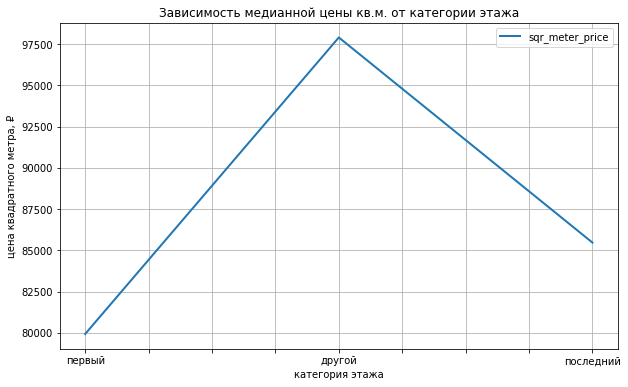

In [138]:
fl_cat_price.plot(
    x='floors_category',
    y='sqr_meter_price',
    figsize=(10,6),
    grid=True,
    linewidth=2
)
plt.title('Зависимость медианной цены кв.м. от категории этажа')
plt.xlabel('категория этажа')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

**Первый и последний этажи в среднем (по медиане, но при среднем арифметическом картина не меняется) обойдутся дешевле, чем  другие. При этом последний - дороже первого. Причины ясны - зачастую вид с последнего этажа приятней чем с первого. Но долгое ожидание лифта и пеший подъём без него всё-таки делают в большинстве случаев последний этаж дешевле чем другие**

Рассмотрим эту зависимость более детально, с группировкой по этажам.

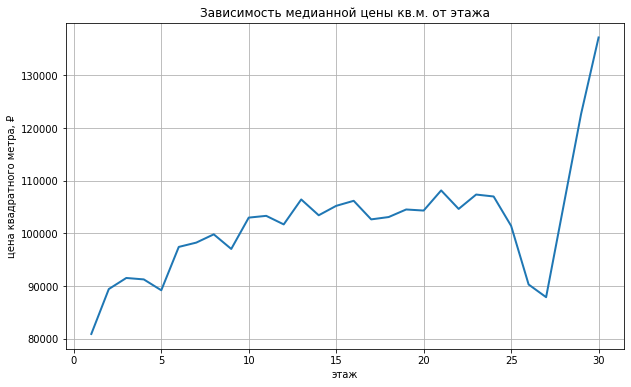

In [139]:
(df_norm.groupby(['level'])['sqr_meter_price']
.median()
.plot(
    x='level',
    y='sqr_meter_price',
    figsize=(10,6),
    grid=True,
    linewidth=2
))
plt.title('Зависимость медианной цены кв.м. от этажа')
plt.xlabel('этаж')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

Видим похожую картину: как с категориями в целом, так и на отдельных участках она повторяется:
- на уровне 5, 9 и 12 этажей видны падения цены, что связанно с большим относительным количеством зданий такой этажности в выборке (их последние этажи формируют такую медиану)
- также снижение цены наблюдается с 23 этажа, потому что 24, 25, 26 - это зачастую последние этажи современных российских ЖК.
- а резкий скачок после 27-го этажа обуслолен небольшим количеством таких значений в выборке и среди них достаточное количество дорогостоящи квартир?

In [140]:
(df_norm.query('level >= 27').sort_values(by='sqr_meter_price',ascending=False)
[['level','last_price','sqr_meter_price']])

,level,last_price,sqr_meter_price
1917,30,10150000.0,137162.0
11079,29,9200000.0,122667.0
13276,27,4450000.0,117105.0
12888,27,7600000.0,108571.0
4091,27,3900000.0,105405.0
8496,27,7500000.0,102319.0
6157,27,2990000.0,89790.0
2629,27,3150021.0,86043.0
23292,27,2980000.0,82732.0
7711,27,4799000.0,79983.0


In [141]:
df_norm.query('level == 30')[['sqr_meter_price']].median()

sqr_meter_price    137162.0
dtype: float64

**Зависимость от даты размещения: день, месяц, год.**

In [142]:
df_norm.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'level',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'sqr_meter_price',
       'day_of_week_expo', 'month_expo', 'year_expo', 'floors_category',
       'living/total', 'kitchen/total', 'city_сenters_km'],
      dtype='object')

In [143]:
df_norm['n_day_of_week_expo'] = df_norm['first_day_exposition'].dt.dayofweek

In [144]:
df_norm

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,level,is_apartment,...,days_exposition,sqr_meter_price,day_of_week_expo,month_expo,year_expo,floors_category,living/total,kitchen/total,city_сenters_km,n_day_of_week_expo
0,20,13000000.0,108.00,2019-03-07,3,2.700,16,51.0,8,False,...,NaN,120370.0,Thursday,2019-03-01,2019-01-01,другой,0.47,0.23,16.0,3
1,7,3350000.0,40.40,2018-12-04,1,2.715,11,18.6,1,False,...,81.0,82921.0,Tuesday,2018-12-01,2018-01-01,первый,0.46,0.27,19.0,1
2,10,5196000.0,56.00,2015-08-20,2,2.560,5,34.3,4,False,...,558.0,92786.0,Thursday,2015-08-01,2015-01-01,другой,0.61,0.15,14.0,3
4,2,10000000.0,100.00,2018-06-19,2,3.030,14,32.0,13,False,...,121.0,100000.0,Tuesday,2018-06-01,2018-01-01,другой,0.32,0.41,8.0,1
5,10,2890000.0,30.40,2018-09-10,1,2.650,12,14.4,5,False,...,55.0,95066.0,Monday,2018-09-01,2018-01-01,другой,0.47,0.30,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23692,2,1350000.0,30.00,2017-07-07,1,2.560,5,17.5,4,False,...,413.0,45000.0,Friday,2017-07-01,2017-01-01,другой,0.58,0.20,NaN,4
23693,9,4600000.0,62.40,2016-08-05,3,2.600,9,40.0,8,False,...,239.0,73718.0,Friday,2016-08-01,2016-01-01,другой,0.64,0.13,34.0,4
23696,18,2500000.0,56.70,2018-02-11,2,2.750,3,29.7,1,False,...,NaN,44092.0,Sunday,2018-02-01,2018-01-01,первый,0.52,NaN,NaN,6
23697,13,11475000.0,76.75,2017-03-28,2,3.000,17,NaN,12,False,...,602.0,149511.0,Tuesday,2017-03-01,2017-01-01,другой,NaN,0.30,10.0,1


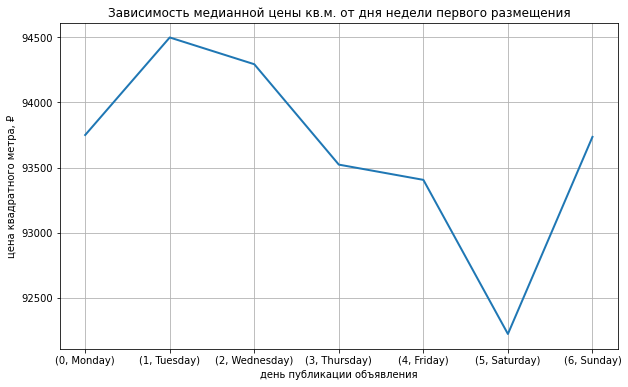

In [145]:
(df_norm.groupby(['n_day_of_week_expo','day_of_week_expo'])['sqr_meter_price'].median()
.plot(
    x='day_of_week_expo',
    y='sqr_meter_price',
    grid=True,
    linewidth=2,
    figsize=(10,6)
))
plt.title('Зависимость медианной цены кв.м. от дня недели первого размещения')
plt.xlabel('день публикации объявления')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

In [146]:
(
    df_norm.groupby(['n_day_of_week_expo','day_of_week_expo'])
    ['sqr_meter_price'].agg(['count','median'])
)

,,count,median
n_day_of_week_expo,day_of_week_expo,,
0,Monday,3041,93750.0
1,Tuesday,3541,94499.0
2,Wednesday,3302,94293.5
3,Thursday,3584,93522.5
4,Friday,3378,93405.5
5,Saturday,1613,92222.0
6,Sunday,1404,93735.5


Диапазон изменения цены от дня недели, когда было размещено объявление, небольшой. Единственный пока очевидный для меня вывод, что в разгаре рабочей недели все хотят заработать побольше и цены ставят повыше.

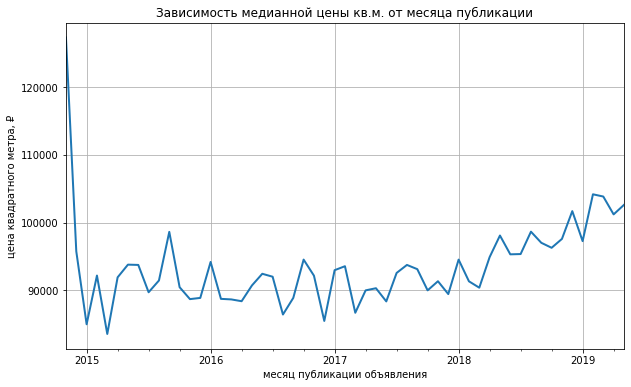

In [147]:
(df_norm.groupby('month_expo')['sqr_meter_price']
.median().plot(
    x='month_expo',
    y='sqr_meter_price',
    grid=True,
    linewidth=2,
    figsize=(10,6)
))
plt.title('Зависимость медианной цены кв.м. от месяца публикации')
plt.xlabel('месяц публикации объявления')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

In [148]:
df_norm[df_norm['year_expo'] == '2014-01-01']['days_exposition'].describe()

count      88.000000
mean      907.545455
std       295.180206
min       554.000000
25%       606.750000
50%       893.500000
75%      1114.000000
max      1580.000000
Name: days_exposition, dtype: float64

Объявления, размещённые в 2014 году (до санкций), обладают более высокой ценой квадратного метра.
После экономического кризиса 2014 года цены на недвижимость упали (вслед за покупательской способностью). И данные объекты продавались в среднем больше 2.5 лет по причине относительно высокой цены. 

Но прослеживается тенденция роста к докризисным ценам к 2019 году. Более наглядно это видно на графике по годам

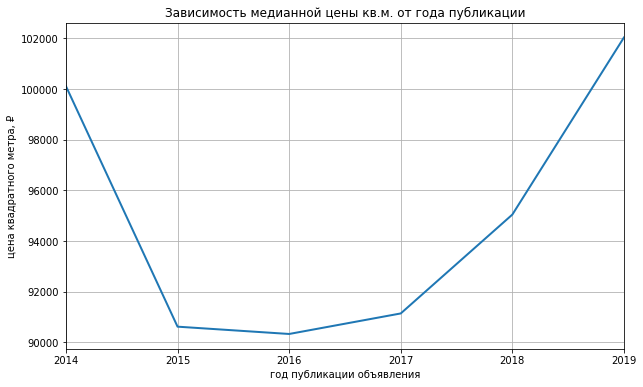

In [149]:
(df_norm.groupby('year_expo')['sqr_meter_price'].median()
.plot(
    x='year_expo',
    y='sqr_meter_price',
    grid=True,
    linewidth=2,
    figsize=(10,6)
))
plt.title('Зависимость медианной цены кв.м. от года публикации')
plt.xlabel('год публикации объявления')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

**Зависимость цены от месяца присутствует, но чтобы её лучше рассмотреть, наложим помесячные графики каждого года на одни оси координат.**

In [150]:
df_norm.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'level',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'sqr_meter_price',
       'day_of_week_expo', 'month_expo', 'year_expo', 'floors_category',
       'living/total', 'kitchen/total', 'city_сenters_km',
       'n_day_of_week_expo'],
      dtype='object')

In [151]:
df_norm['month'] = df_norm['first_day_exposition'].dt.month

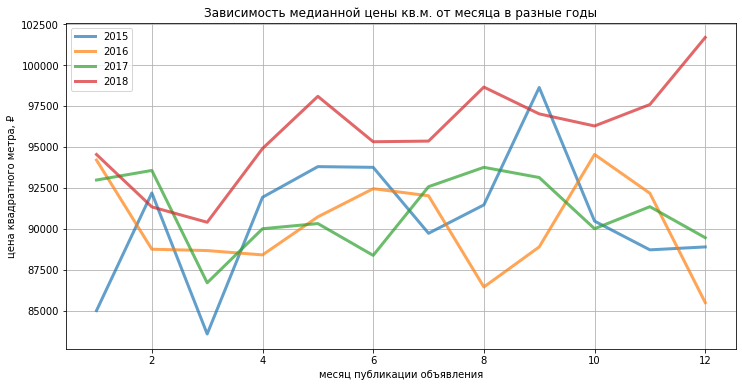

In [152]:
#график по месяцам за 2015 
ax = (df_norm.query('year_expo == "2015-01-01"').groupby('month')['sqr_meter_price'].median()
.plot(
    x='month',
    y='sqr_meter_price',
    linewidth=3,
    figsize=(12,6),
    alpha=0.7,
    label='2015',
    legend=True
))

#график по месяцам за 2016
(df_norm.query('year_expo == "2016-01-01"').groupby('month')['sqr_meter_price'].median()
.plot(
    x='month',
    y='sqr_meter_price',
    grid=True,
    linewidth=3,
    figsize=(12,6),
    alpha=0.7,
    label='2016',
    ax=ax,
    legend=True
))

#график по месяцам за 2017
(df_norm.query('year_expo == "2017-01-01"').groupby('month')['sqr_meter_price'].median()
.plot(
    x='month',
    y='sqr_meter_price',
    grid=True,
    linewidth=3,
    figsize=(12,6),
    alpha=0.7,
    label='2017',
    ax=ax,
    legend=True
))

#график по месяцам за 2018
(df_norm.query('year_expo == "2018-01-01"').groupby('month')['sqr_meter_price'].median()
.plot(
    x='month',
    y='sqr_meter_price',
    grid=True,
    linewidth=3,
    figsize=(12,6),
    alpha=0.7,
    label='2018',
    ax=ax,
    legend=True
))
plt.title('Зависимость медианной цены кв.м. от месяца в разные годы')
plt.xlabel('месяц публикации объявления')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

- Цена зависит от месяца, но с каждым годом эта зависимость сильно меняется. Вплоть до противоположных сезоных трендов (как 2016й и 2018й годы на большей части годового графика)
- Происходит это, вероятнее всего, в связи с экономической ситуацией в стране, весьма нестабильной.
- С 2018го, когда экономика более-менее начала оправляться от 2014го наблюдается рост цен.
- Но тем не менее, характерногй зависимости между ценой и месяцем **(независимо от года)** нет, если не учитывать экономические факторы рынка недвижимости (льготные ипотеки, программы гос. поддержки и прочие явления, существенно влияющие на спрос и ,соответственно, формирование цены)


**Рассмотрим 10 населённых пунктов с наибольшим числом объявлений и узнаем среднюю цену квадратного метра по ним.**

In [153]:
max_ads = (
    df_norm.groupby('locality_name')['sqr_meter_price'].
    agg(['count','mean','median']).
    sort_values(by='count',ascending=False).
    head(11).reset_index()
)

In [154]:
max_ads.sort_values('mean',ascending=False)

,locality_name,count,mean,median
0,Санкт-Петербург,12898,107488.849977,103093.0
5,Пушкин,317,101434.220820,98601.0
2,Кудрово,414,94883.181159,95067.0
7,поселок Парголово,282,90836.446809,92330.5
1,Мурино,539,85940.525046,86043.0
10,Петергоф,183,83586.316940,81818.0
3,поселок Шушары,398,78852.567839,77048.5
6,Колпино,301,75729.465116,75000.0
8,Гатчина,280,68728.800000,67746.5
4,Всеволожск,362,67082.091160,65526.0


Выборг - самый удалённый населённый пункт в этом списке. Оттуда и наименьшая по выборке средняя цена.

Но Пушкин - не самый близкий к Петербургу город, но второй по значению средней цены.

Это связано с развитой инфраструктурой города: там много исторических памятников архитектуры и градостроительства, за которыми хорошо ухаживают. В этом городе расположены известные на весь мир Царское Село и Екатерининский дворец. А, соответственно, туристический поток и связанные с этим возможности для развития определённых видов бизнеса оказывают влияние на уровень цен на жилую недвижимость в городе Пушкин.

**Рассмотрим зависимость между удалённостью от центра и стоимостью квадратного метра для Санкт-Петербурга.**

Ранее мы уже определили, что граница очерчивающая центр Санкт-Петербурга находится в пределах радиуса 2 км от Дворцовой площади.

In [155]:
df_spb_center = df_norm.query('locality_name == "Санкт-Петербург" & city_сenters_km <= 2.0')

In [156]:
df_all_spb = df_norm.query('locality_name == "Санкт-Петербург"')

**Рассмотрим и сравним значения площади квартир в центре и по всему городу**

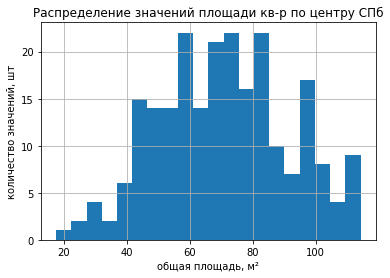

In [157]:
df_spb_center['total_area'].hist(bins=20)
plt.title('Распределение значений площади кв-р по центру СПб')
plt.xlabel('общая площадь, м²')
plt.ylabel('количество значений, шт')
plt.show()

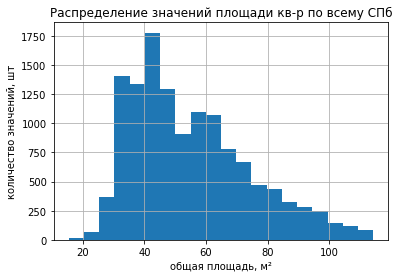

In [158]:
df_all_spb['total_area'].hist(bins=20)
plt.title('Распределение значений площади кв-р по всему СПб')
plt.xlabel('общая площадь, м²')
plt.ylabel('количество значений, шт')
plt.show()

In [159]:
spb_center_area = pd.DataFrame(df_spb_center['total_area'].describe()).reset_index()

In [160]:
spb_center_area.columns = ['param', 'center_spb']

In [161]:
all_spb_area = pd.DataFrame(df_all_spb['total_area'].describe()).reset_index()

In [162]:
all_spb_area.columns = ['param', 'all_spb']

In [163]:
all_spb_area.merge(spb_center_area,on='param')

,param,all_spb,center_spb
0,count,12898.000000,230.000000
1,mean,55.084994,70.941043
2,std,19.131084,20.591590
3,min,15.500000,17.600000
4,25%,40.400000,55.750000
5,50%,51.000000,70.450000
6,75%,66.675000,85.000000
7,max,114.200000,114.200000


**В центре Санкт-Петербурга в среднем площадь продающихся квартир на 16 м² больше (71 против 55), чем по всему городу.**


**Рассмотрим и сравним значения цены квадратного метра квартир в центре и по всему городу**

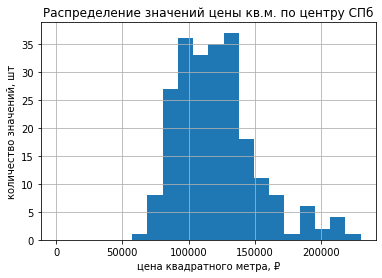

In [164]:
df_spb_center['sqr_meter_price'].hist(bins=20,range=(0,230000))
plt.title('Распределение значений цены кв.м. по центру СПб')
plt.xlabel('цена квадратного метра, ₽')
plt.ylabel('количество значений, шт')
plt.show()

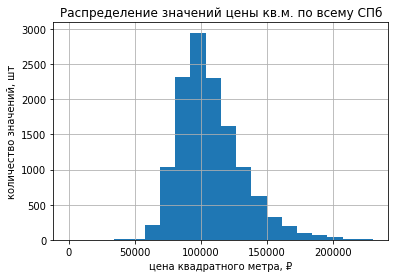

In [165]:
df_all_spb['sqr_meter_price'].hist(bins=20,range=(0,230000))
plt.title('Распределение значений цены кв.м. по всему СПб')
plt.xlabel('цена квадратного метра, ₽')
plt.ylabel('количество значений, шт')
plt.show()

In [166]:
spb_center_price_m = pd.DataFrame(df_spb_center['sqr_meter_price'].describe()).reset_index()

In [167]:
spb_center_price_m.columns = ['param', 'center_spb']

In [168]:
all_spb_price_m = pd.DataFrame(df_all_spb['sqr_meter_price'].describe()).reset_index()

In [169]:
all_spb_price_m.columns = ['param', 'all_spb']

In [170]:
all_spb_price_m.merge(spb_center_price_m,on='param')

,param,all_spb,center_spb
0,count,12898.000000,230.000000
1,mean,107488.849977,123327.165217
2,std,25059.768417,36491.679172
3,min,17391.000000,66872.000000
4,25%,90380.500000,99385.000000
5,50%,103093.000000,117337.500000
6,75%,120311.250000,136104.500000
7,max,387097.000000,387097.000000


**Как и ожидалось, средние значения цены квадратного метра в центре ощутимо больше, чем среднее по городу. Далее проверим как меняется значения цены квадратного метра в пределах центра.**

**Рассмотрим и сравним количество комнат в объявлениях по центру и по всему городу**

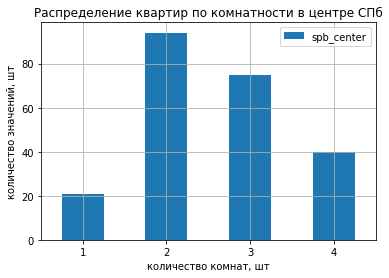

In [171]:
df_spb_center.groupby('rooms')['rooms'].count().plot(
    kind='bar', 
    x='rooms',  
    grid=True,
    label='spb_center',
    legend=True
)
plt.xticks(rotation=0)
plt.title('Распределение квартир по комнатности в центре СПб')
plt.xlabel('количество комнат, шт')
plt.ylabel('количество значений, шт')
plt.show()

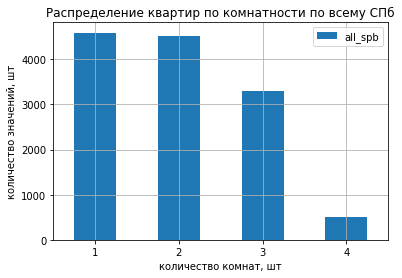

In [172]:
df_all_spb.groupby('rooms')['rooms'].count().plot(
    kind='bar', 
    x='rooms', 
    grid=True,
    label='all_spb',
    legend=True
)
plt.xticks(rotation=0)
plt.title('Распределение квартир по комнатности по всему СПб')
plt.xlabel('количество комнат, шт')
plt.ylabel('количество значений, шт')
plt.show()

**В центре относительная доля однушек ниже, чем двухкомнатных квартир, а 3 и 4 комнатных квартир наоборот выше, чем по всему городу. И это подтверждает сравнение площадей "центр vs. весь город"**


**Рассмотрим и сравним значения высоты потолка в объявлениях по центру и по всему городу**

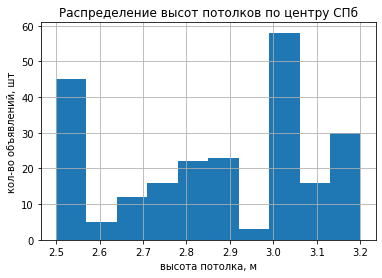

In [173]:
df_spb_center['ceiling_height'].hist()
plt.title('Распределение высот потолков по центру СПб')
plt.xlabel('высота потолка, м')
plt.ylabel('кол-во объявлений, шт')
plt.show()

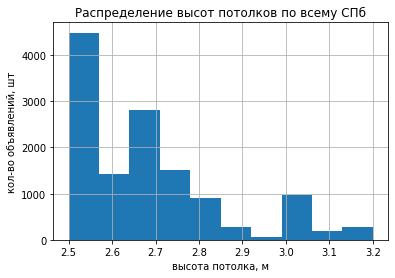

In [174]:
df_all_spb['ceiling_height'].hist()
plt.title('Распределение высот потолков по всему СПб')
plt.xlabel('высота потолка, м')
plt.ylabel('кол-во объявлений, шт')
plt.show()

In [175]:
spb_center_ceiling = pd.DataFrame(df_spb_center['ceiling_height'].describe()).reset_index()

In [176]:
spb_center_ceiling.columns = ['param', 'center_spb']

In [177]:
all_spb_ceiling = pd.DataFrame(df_all_spb['ceiling_height'].describe()).reset_index()

In [178]:
all_spb_ceiling.columns = ['param', 'all_spb']

In [179]:
all_spb_ceiling.merge(spb_center_ceiling,on='param')

,param,all_spb,center_spb
0,count,12898.000000,230.000000
1,mean,2.681350,2.868978
2,std,0.166601,0.217091
3,min,2.500000,2.500000
4,25%,2.550000,2.700000
5,50%,2.650000,2.900000
6,75%,2.750000,3.000000
7,max,3.200000,3.200000


**Среднее арифметическое и медиана потолков в центре выше, чем по всему городу, потому что в центре большая доля квартир с высокими потолками (3м на гистограмме центра)**

**Проверим, каковы зависимости стоимости квадратного метра от:**
- число комнат, 
- этаж, 
- удалённость от центра, 
- дата размещения объявления.


**Число комнат**

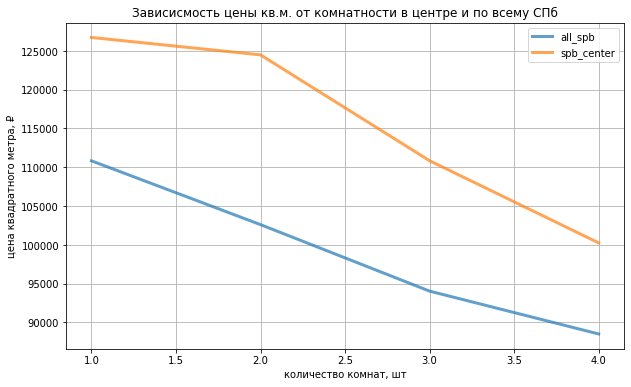

In [180]:
sx = (df_all_spb.groupby('rooms')['sqr_meter_price']
.median()
.plot(
    x='rooms',
    y='sqr_meter_price',
    figsize=(10,6),
    grid=True,
    linewidth=3,
    alpha=0.7,
    label='all_spb',
    legend=True
))

(df_spb_center.groupby('rooms')['sqr_meter_price'].median()
.plot(
    x='rooms',
    y='sqr_meter_price',
    grid=True,
    linewidth=3,
    figsize=(10,6),
    alpha=0.7,
    label='spb_center',
    ax=sx,
    legend=True
))
plt.title('Зависисмость цены кв.м. от комнатности в центре и по всему СПб')
plt.xlabel('количество комнат, шт')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

**Зависимости центральной выборки и общегородской практически идентичны, за исключением небольшого излома на центральном графике. Вероятно, из-за локации цена медленнее снижается при увеличении комнатности на интервале 1к - 2к.**


**Этаж (первый, другой, последний)**

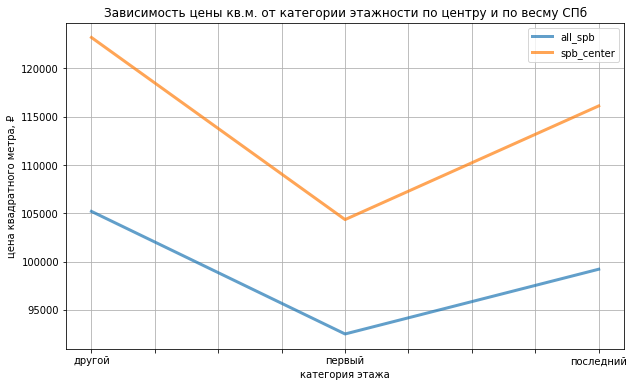

In [181]:
sx = (df_all_spb.groupby('floors_category')['sqr_meter_price']
.median()
.plot(
    x='floors_category',
    y='sqr_meter_price',
    figsize=(10,6),
    grid=True,
    linewidth=3,
    alpha=0.7,
    label='all_spb',
    legend=True
))

(df_spb_center.groupby('floors_category')['sqr_meter_price'].median()
.plot(
    x='floors_category',
    y='sqr_meter_price',
    grid=True,
    linewidth=3,
    figsize=(10,6),
    alpha=0.7,
    label='spb_center',
    ax=sx,
    legend=True
))
plt.title('Зависимость цены кв.м. от категории этажности по центру и по весму СПб')
plt.xlabel('категория этажа')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

**Зависимость цены от категории этажа в центре аналогичная зависимости по всему городу.**


**Удалённость от центра**

In [182]:
df_norm.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'level',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'sqr_meter_price',
       'day_of_week_expo', 'month_expo', 'year_expo', 'floors_category',
       'living/total', 'kitchen/total', 'city_сenters_km',
       'n_day_of_week_expo', 'month'],
      dtype='object')

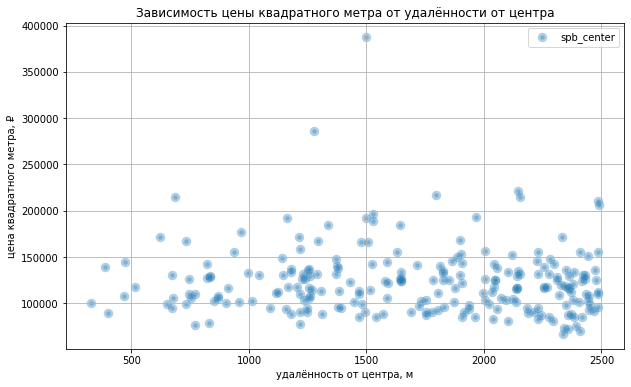

In [183]:
df_spb_center.plot(
    x='city_centers_nearest',
    y='sqr_meter_price',
    kind='scatter',
    grid=True,
    linewidth=5,
    figsize=(10,6),
    label='spb_center',
    legend=True,
    alpha=0.35
)
plt.title('Зависимость цены квадратного метра от удалённости от центра')
plt.xlabel('удалённость от центра, м')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

**В пределах центра цена практически не зависит от расстояния в метрах относительно центральной точки города в отличие от целого города, где район и удалённость от центра оказывает существенное влияние на цену. Лишь на границе центральной зоны стоимость квадратного метра начинает снижаться (ближе к 2500 м)**


**Дата размещения объявления**

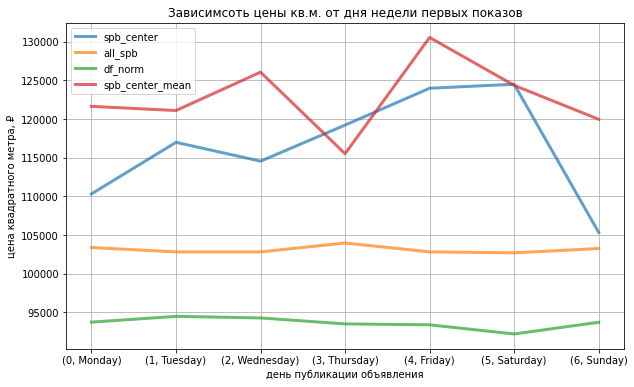

In [184]:
dx = (df_spb_center.groupby(['n_day_of_week_expo','day_of_week_expo'])['sqr_meter_price'].median()
.plot(
    x='day_of_week_expo',
    y='sqr_meter_price',
    figsize=(10,6),
    grid=True,
    linewidth=3,
    alpha=0.7,
    label='spb_center',
    legend=True
))

(df_all_spb.groupby(['n_day_of_week_expo','day_of_week_expo'])['sqr_meter_price'].median()
.plot(
    x='day_of_week_expo',
    y='sqr_meter_price',
    figsize=(10,6),
    grid=True,
    linewidth=3,
    alpha=0.7,
    label='all_spb',
    legend=True,
    ax=dx
))

(df_norm.groupby(['n_day_of_week_expo','day_of_week_expo'])['sqr_meter_price'].median()
.plot(
    x='day_of_week_expo',
    y='sqr_meter_price',
    figsize=(10,6),
    grid=True,
    linewidth=3,
    alpha=0.7,
    label='df_norm',
    legend=True,
    ax=dx
))

(df_spb_center.groupby(['n_day_of_week_expo','day_of_week_expo'])['sqr_meter_price'].mean()
.plot(
    x='day_of_week_expo',
    y='sqr_meter_price',
    figsize=(10,6),
    grid=True,
    linewidth=3,
    alpha=0.7,
    label='spb_center_mean',
    legend=True,
    ax=dx
))
plt.title('Зависимсоть цены кв.м. от дня недели первых показов')
plt.xlabel('день публикации объявления')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

**Цена квадратного метра в центре на первый взгляд зависит от дня недели размещения объявления.
Чего не скажешь про весь город и всю выборку (в пределах нормальных значений). Но эта кажущаяся зависимость является следствием небольшого числа объявлений: в качестве доказательства добавил график(красный) значений по центру, но уже средних арифметических, а не медианных.**

In [185]:
df_norm.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'level',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'sqr_meter_price',
       'day_of_week_expo', 'month_expo', 'year_expo', 'floors_category',
       'living/total', 'kitchen/total', 'city_сenters_km',
       'n_day_of_week_expo', 'month'],
      dtype='object')

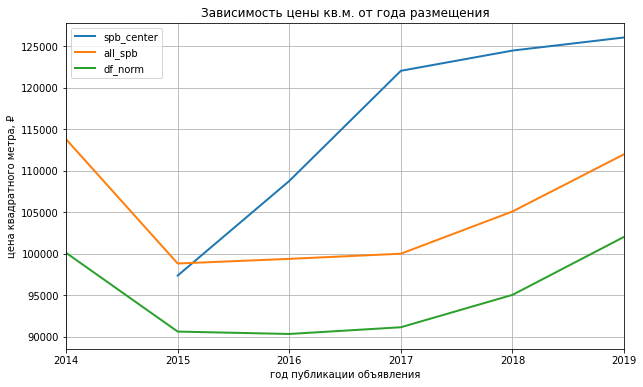

In [186]:
yx = (df_spb_center.groupby('year_expo')['sqr_meter_price']
.median().plot(
    x='year_expo',
    y='sqr_meter_price',
    grid=True,
    linewidth=2,
    figsize=(10,6),
    label='spb_center',
    legend=True
    
))

(df_all_spb.groupby('year_expo')['sqr_meter_price']
.median().plot(
    x='year_expo',
    y='sqr_meter_price',
    grid=True,
    linewidth=2,
    figsize=(10,6),
    ax=yx,
    label='all_spb',
    legend=True
))

(df_norm.groupby('year_expo')['sqr_meter_price']
.median().plot(
    x='year_expo',
    y='sqr_meter_price',
    grid=True,
    linewidth=2,
    figsize=(10,6),
    ax=yx,
    label='df_norm',
    legend=True
))
plt.title('Зависимость цены кв.м. от года размещения')
plt.xlabel('год публикации объявления')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

**После снижения цены квадратного метра до 2015, в центре Санкт-Петербурга повышение цен на недвижимсоть происходило быстрее, чем по всему остальному городу и области**

**Посмотрим динамику изменения цен по месяцам в сравнении: центр СПБ / весь СПБ / область** 

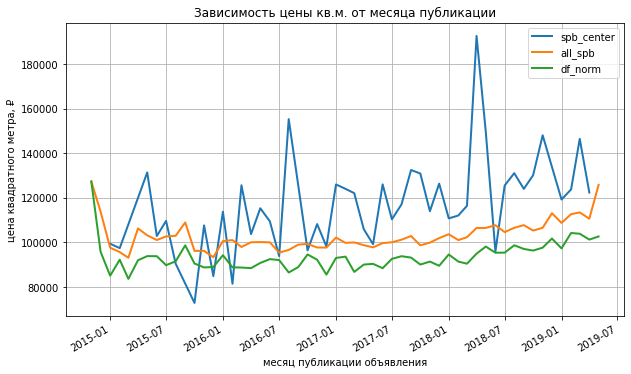

In [187]:
mx = (df_spb_center.groupby('month_expo')['sqr_meter_price']
.median().plot(
    x='month_expo',
    y='sqr_meter_price',
    grid=True,
    linewidth=2,
    figsize=(10,6),
    label='spb_center',
    legend=True
))

(df_all_spb.groupby('month_expo')['sqr_meter_price']
.median().plot(
    x='month_expo',
    y='sqr_meter_price',
    grid=True,
    linewidth=2,
    figsize=(10,6),
    ax=mx,
    label='all_spb',
    legend=True
))

(df_norm.groupby('month_expo')['sqr_meter_price']
.median().plot(
    x='month_expo',
    y='sqr_meter_price',
    grid=True,
    linewidth=2,
    figsize=(10,6),
    ax=mx,
    label='df_norm',
    legend=True
))
plt.title('Зависимость цены кв.м. от месяца публикации')
plt.xlabel('месяц публикации объявления')
plt.ylabel('цена квадратного метра, ₽')
plt.show()

Динамика цен от месяца к месяцу по всему городу и области в большей степени похожи, отличаются уровнями цен.
А вот изменение цен в центре совершенно непохоже. В первую очередь из-за небольшого количества данных. Их едва хватило на годовой график. Поэтому не будем искать эту связь: как и в случае с основным датафреймом, месяц без привязки к году не влиет. 


**Сезонности по месяцам, не зависящей от экономической ситуации в стране в нашем наборе данных нет.**


**День размещения объявления также не влияет цену квадратного метра**


**А вот год уже влияет на изменение цены, но не как сезонный период, а как ощутимая единица времени, за которую может изменяться экономическое положение в стране и сфере недвижимости.**

## Общий вывод

1. Цена квадратного метра зависит от комнатности и общей площади соответственно:

    1.1  при прочих равных условиях квартира меньшего размера (до студии, комуналки не в счёт) имеет более высокую цену квадратного метра. 

    1.2  данное утверждение верно для квартир из имеющейся выборки с площадью: от 15,5 до 114,25 квадратных метров

    1.3  если это условие не выполняется - продавец, вероятно, завысил цену. Понятный рыночный механизм - оптом дешевле.

2. Больше комнат - ниже цена квадратного метра. Но данная закономерность прослеживается только в случае типового жилья с комнатностью от 1 до 5. После 5 начинают действовать законы элитной недвижимости и цена квадратного метра увеличивается.

    2.1  Для примера: медианная цена кв. метра студии и 1к квартиры составляет около 100 тысяч рублей, а для 5к квартиры она уже составляет около 82,5 тысяч рублей.

3. Расположение в центре города - безусловно веская причина для наиболее высоких цен на недвижимость. Средняя цена кв. метра в центре (для типового массового жилья) может достигать 124 тысяч рублей, в то время как в спальных районах она колеблется от 105 до 96 тысяч рублей. Но ещё более высокие цены, чем в центре, до 128 тысяч рублей, могут быть в районах, удалённых от центра на небольшое расстояние (5км в нашем случае).  Потому что в этих районах уже разрешена современная застройка с благоустроенной придомовой территорией. А также, в таких районах, как правило, тише.

4. Этаж - параметр влияющий на цену также явно, как комнатность и общая площадь: первый этаж - самый дешёвый, последний жилой этаж - дороже первого, но дешевле всех остальных. Для примера: средняя цена кв. метра на первом этаже - около 80 тысяч рублей, на последнем - 86 тысяч рублей, а на других этажах она составляет около 100 тысяч рублей.

5. Если не учитывать экономические факторы рынка недвижимости (льготные ипотеки, программы гос. поддержки и прочие явления, существенно влияющие на спрос и формирование цены), то прогнозируемой зависимости меджду датой размещения (день, месяц, год) нет. Это наглядно просматривается на графике "по годам", с которым можно соотнести экономическую ситуацию в стране: так в 2014м медианная цена кв. метра - около 100 тысяч рублей, в 2015м (после санкций) - медианная цена кв. метра уже около 91 тысячи рублей, а к 2019-му, по мере восстановления экономики страны медианная цена постепенно выросла до 102 тысяч за кв. метр.